# Part F: Generate figures and make analysis

## Introduction
This notebook contains _all code_ that has been used to create the figures and perform the analysis for the paper "Can more detailed geological maps improve streamflow prediction in ungauged basins?" paper by do Nascimento et al. (in review). To be able to run this notebook, please ensure that you have downloaded the acompanying data of the paper, and to have run all the codes before. All links can be found in the data section of the paper.

Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

## Requirements

**Files**

- estreams_gauging_stations.csv https://doi.org/10.5281/zenodo.14778580 (Last access: 11 February 2025)
- estreams_geology_moselle_regional_attributes.csv https://doi.org/10.5281/zenodo.14778580 (Last access: 15 February 2025)
- estreams_attributes_filtered_quality_geology_v01.csv https://github.com/thiagovmdon/LSH-quality_geology (Last access: 11 February 2025)



## Import modules

In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
#import spotpy
import time
import os
import tqdm as tqdm
#import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream
#warnings.filterwarnings("ignore")
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import rasterio
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Configurations

In [2]:
# Path to where the EStreams dataset is stored
# Eawag
path_estreams = r'/Users/nascimth/Documents/data/EStreams'

## Mac
#path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

path_data = r"/Users/nascimth/Documents/data"

## Import data

### Shapefiles

In [3]:
moselle=gpd.read_file(r"../data/shps/moselle_delienation.shp")
rivers_moselle=gpd.read_file(r"../data/shps/rivers_moselle.shp")
catchment_boundaries = gpd.read_file(path_data+'//EStreams/shapefiles/estreams_catchments.shp')
catchment_boundaries.set_index("basin_id", inplace=True)

### Geological maps (clipped to the Moselle basin)


In [4]:
##################################################################################################################
# Global geology clipped to the Moselle catchment
GLiM_moselle = gpd.read_file(path_data+"/gis/paper_moselle//raster/glim_moselle_wgs.shp")

attribute_field = 'xx'
GLiM_moselle_dissolved = GLiM_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
GLiM_moselle_dissolved["class"] = GLiM_moselle_dissolved.index

# Define the permeability columns dictionary
permeability_columns_glim = {
    "very low": ['ev', 'ig', 'pa', 'pb', 'va', 'vb', "wb"],
    "low": ['mt', 'pi', 'py', 'vi'],
    "medium": ['sc', 'sm'],
    "high": ['su', 'ss']
}

# Create a new column for reclassified permeability
def reclassify_glim_class(class_name):
    for permeability, classes in permeability_columns_glim.items():
        if class_name in classes:
            return permeability
    return None

GLiM_moselle_dissolved['permeability'] = GLiM_moselle_dissolved['class'].apply(reclassify_glim_class)

##################################################################################################################
# Continental geology clipped to the Moselle catchment
geology_median_moselle = gpd.read_file(path_data+"/gis/paper_moselle//raster/geology_median_moselle_wgs.shp")

attribute_field = 'LEVEL3'
geology_median_moselle_dissolved = geology_median_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_median_moselle_dissolved["class"] = geology_median_moselle_dissolved.index

# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Conglomerates", "Conglomerates and sands", "Gravels", 
             "Sands", "Sandstones", "Sandstones and sands"],
    "medium": ["Conglomerates and clays", "Gneisses", "Limestones", 
               "Limestones and sands", "Sandstones and clays", "Sandstones and marls",
               "Limestones and clays", "Limestones and marls", "Marlstones and sands"],
    "low": ["Claystones and clays", "Marbles",
              "Marls", "Marlstones", "Marlstones and clays", 
              "Marlstones and marls", "Phyllites", "Schists",
              "Silts"],
    "very low": ["Plutonic rocks", "Volcanic rocks", 
                    "Inland water", "Snow field / ice field",
                    "Clays",  'Quartzites', "Shales"]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_median_moselle_dissolved['permeability'] = geology_median_moselle_dissolved['class'].apply(reclassify_geology_class)

##################################################################################################################
# Regional geology clipped to the Moselle catchment
geology_high_moselle = gpd.read_file(path_data+'/gis/lithology/moselle_hr_ff.shp')

attribute_field = 'Labels01'
geology_high_moselle_dissolved = geology_high_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_high_moselle_dissolved["class"] = geology_high_moselle_dissolved.index

# Set the CRS to WGS84
geology_high_moselle_dissolved = geology_high_moselle_dissolved.to_crs(epsg=4326)


# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Alluvium", 'Coal', 'Conglomerate', 'Gravel and sand',
             'Sand', 'Sand and gravel', 'Sandstone and conglomerate', 'Sandstone'
        ],
    
    "medium": ['Limestone', 'Sandstone and marl', 'Sandstone and schist',
              'Sandstone, conglomerate and marl'],
    
    "low": ['Arkose', 'Dolomite rock', 'Limestone and marl', 'Marl', 
             'Marl and dolomite', 'Marl and limestone', 'Marl and sandstone',
             'Sandstone and siltstone', 'Sandstone, siltstone and schist', 
              'Schist and sandstone', 'Silt',  'Silt and schist', 'Siltstone, sandstone and schist'
              ,"Siltstone"
             ],
    
    "very low": ['Cristallin basement', 'Plutonic rock',  'Quarzite',
                    'Schist','Volcanic rock' 
                   ]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_high_moselle_dissolved['permeability'] = geology_high_moselle_dissolved['class'].apply(reclassify_geology_class)

### Topography

Current CRS: EPSG:4326
Image is already in WGS84 CRS.


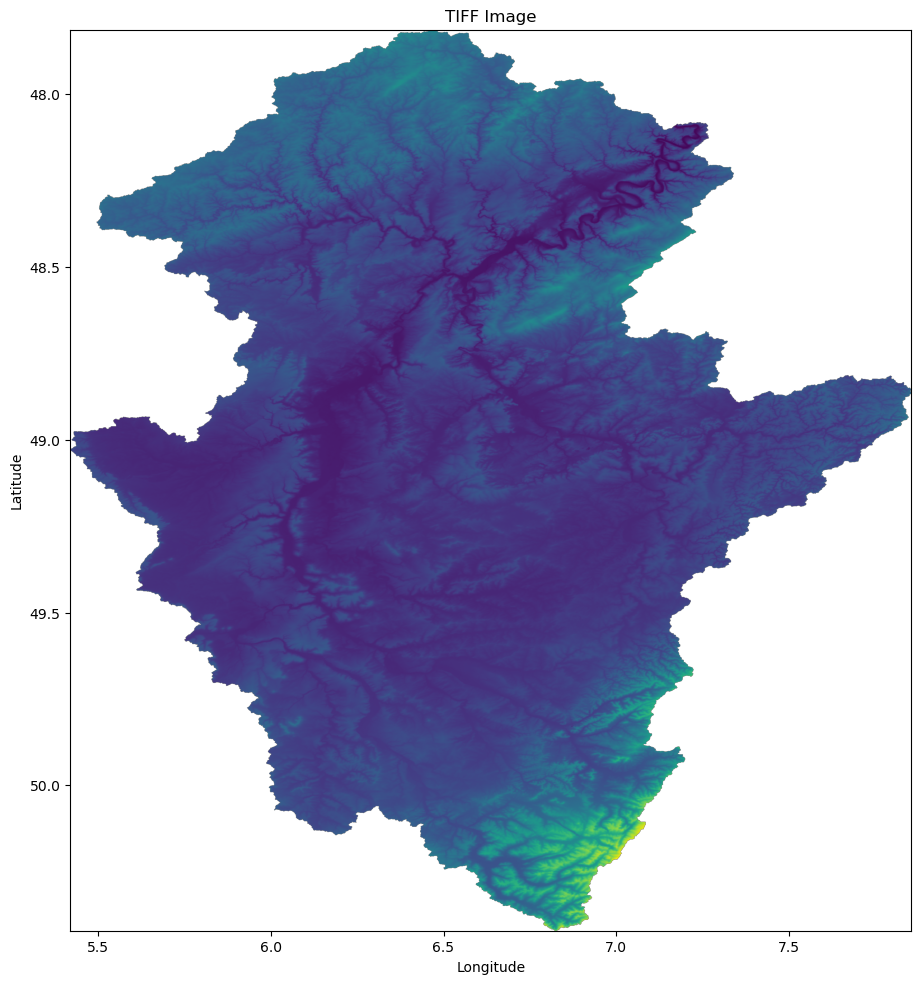

In [5]:
##################################################################################################################
# Terrain (elevation)
# Path to the TIFF file
tiff_path = path_data+"/gis/paper_moselle/raster/elevation/moselle_srtm.tif"

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    # Check the current CRS
    current_crs = src.crs
    print(f'Current CRS: {current_crs}')

    # Define the target CRS (WGS84)
    dst_crs = 'EPSG:4326'  # WGS84

    # If the current CRS is not WGS84, reproject the image
    if current_crs != dst_crs:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create an in-memory array to hold the reprojected data
        reprojected_image = rasterio.io.MemoryFile().open(**kwargs)

        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(reprojected_image, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

        # Read the reprojected image
        elevation_wgs = reprojected_image.read(1)

        print(f'Image reprojected to WGS84 and stored in-memory.')
    else:
        # Read the original image if it is already in WGS84
        elevation_wgs = src.read(1)
        transform = src.transform
        print('Image is already in WGS84 CRS.')

# Calculate the extent
left, bottom, right, top = transform * (0, 0), transform * (elevation_wgs.shape[1], 0), transform * (elevation_wgs.shape[1], elevation_wgs.shape[0]), transform * (0, elevation_wgs.shape[0])
extent = (left[0], right[0], bottom[1], top[1])

# Plot the image with the correct extent
fig, ax = plt.subplots(1, 1, figsize=(16.6, 11.7))
ax.imshow(elevation_wgs, cmap='viridis', extent=extent)
ax.set_title('TIFF Image')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Network and attributes

In [6]:
# Read the gauges network metadata (from EStreams):
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Attributes already filtered from EStreams previously in do Nascimento et al. (2025a):
estreams_attributes = pd.read_csv('../data/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')
estreams_attributes.set_index("basin_id", inplace = True)

# Geological attributes (regional scale). Same ones provided in do Nascimento et al. (2025a):
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')
geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)


# Read the dataset network
estreams_attributes_clipped_filters = pd.read_csv(R'../data/network_estreams_moselle_108_gauges.csv', encoding='utf-8')
estreams_attributes_clipped_filters.set_index("basin_id", inplace = True)

## Preprocessing
### Network organization

In [7]:
# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)


# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

### Geological data organization

In [8]:
# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

### Attributes organization

In [9]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])

100%|██████████| 1/1 [00:00<00:00, 910.62it/s]


## Merging simulations

In [104]:
# Base path to your NetCDF files
base_path = Path(r"../results/sim/space-time/notconcatenated")
base_path_output= Path(r"../results/sim/space-time")
# List of group suffixes
group_suffixes = [f"Group_{i}" for i in range(1, 8)]

# Loop through each group
for group in group_suffixes:
    # Load datasets
    ds_compl = xr.load_dataset(base_path / f"simu_compl_{group}.nc")
    ds_nogeo = xr.load_dataset(base_path / f"simu_nogeo_{group}.nc")

    # Merge and save
    ds_merged = xr.merge([ds_compl, ds_nogeo])
    output_path = base_path_output / f"simu_{group}.nc"
    ds_merged.to_netcdf(output_path, engine="netcdf4")

In [122]:
# Base path to your NetCDF files
base_path = Path(r"../results/sim/space/notconcatenated")
base_path_output= Path(r"../results/sim/space")
# List of group suffixes
group_suffixes = [f"Group_{i}" for i in range(1, 8)]

# Loop through each group
for group in group_suffixes:
    # Load datasets
    ds_compl = xr.load_dataset(base_path / f"simu_compl_{group}.nc")
    ds_nogeo = xr.load_dataset(base_path / f"simu_nogeo_{group}.nc")

    # Merge and save
    ds_merged = xr.merge([ds_compl, ds_nogeo])
    output_path = base_path_output / f"simu_{group}.nc"
    ds_merged.to_netcdf(output_path, engine="netcdf4")

## Load the simulations

In [130]:
# Function to load the simulations and merge with the observations
def load_group_with_inputs(group: str, base_path: Path) -> xr.Dataset:
    """
    Load simulation + inputs for a given group into a single merged xarray.Dataset.
    
    Assumes both files contain the same gauge_id and date dimensions.

    Parameters:
    - group (str): Group name like "Group_3"
    - base_path (Path): Directory where both simu_Group_X.nc and inputs_Group_X.nc live

    Returns:
    - xarray.Dataset with all variables merged
    """
    # Load the group simulation file
    ds_sim = xr.load_dataset(base_path / f"simu_{group}.nc")
    
    # Load the group input file
    ds_inputs = xr.load_dataset(base_path / f"inputs.nc")
    
    # Merge datasets (assumes same gauge_id and date alignment)
    ds_merged = xr.merge([ds_sim, ds_inputs])

    return ds_merged


# Function to load the simulations and merge with the observations
def load_group_with_inputs_cal(group: str, base_path: Path) -> xr.Dataset:
    """
    Load simulation + inputs for a given group into a single merged xarray.Dataset.
    
    Assumes both files contain the same gauge_id and date dimensions.

    Parameters:
    - group (str): Group name like "Group_3"
    - base_path (Path): Directory where both simu_Group_X.nc and inputs_Group_X.nc live

    Returns:
    - xarray.Dataset with all variables merged
    """
    # Load the group simulation file
    ds_sim = xr.load_dataset(base_path / f"simu_cal_{group}.nc")
    
    # Load the group input file
    ds_inputs = xr.load_dataset(base_path / f"inputs.nc")
    
    # Merge datasets (assumes same gauge_id and date alignment)
    ds_merged = xr.merge([ds_sim, ds_inputs])

    return ds_merged


In [ ]:
# Define the NSE adjusted function
def compute_nse(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = 1 - np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


In [ ]:
from neuralhydrology.evaluation.signatures import (
    baseflow_index, hfd_mean, high_q_dur, high_q_freq, low_q_dur,
    low_q_freq, q5, q95, q_mean, runoff_ratio, slope_fdc, stream_elas, zero_q_freq
)

In [301]:
from pathlib import Path
import xarray as xr

# Base directory and group names
base_dir = Path("../results/sim/space-time")
group_names = [f"Group_{i}" for i in range(1, 8)]

# Load all groups into a list of datasets
datasets = [load_group_with_inputs(group, base_dir) for group in group_names]

# Merge into one dataset with a new dimension: "group"
combined = xr.concat(datasets, dim="group")

# Compute the average across groups
ds_mean = combined.mean(dim="group")

# Initialize dict to collect NSEs
nse_results = {}

# Define the time range
start_date = "1989-10-01"
end_date = "2015-09-30"

selected_gauge_ids = estreams_attributes_clipped_filters.index.unique().tolist()
# Clip by gauges and time
ds_mean_clipped = ds_mean.sel(
    gauge_id=selected_gauge_ids,
    date=slice(start_date, end_date)
)

# Loop over gauges and compute NSE within defined time period
for gauge_id in ds_mean_clipped.gauge_id.values:
    # Subset for gauge and time period
    ts = ds_mean_clipped.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    obs = ts["observation"].values

    nse_results[gauge_id] = {
        'nse_nogeo': compute_nse(obs, ts["nogeology"].values),
        'nse_g1comp': compute_nse(obs, ts["global"].values),
        'nse_c1comp': compute_nse(obs, ts["continental"].values),
        'nse_r1comp': compute_nse(obs, ts["regional"].values),
    }


# Convert to DataFrame
data_diff_val_complete_dict_plot = pd.DataFrame.from_dict(nse_results, orient='index')


# Sources to evaluate
sources = ['observation', 'regional', 'continental', 'global', 'nogeology']

MIN_VALID_POINTS = 365  # You can adjust this threshold if needed

def safe_bfi(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return baseflow_index(masked_sim, alpha=0.925, warmup=365, n_passes=3)[0]

def safe_hfd(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return hfd_mean(masked_sim, datetime_coord="date")

def safe_slope(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return slope_fdc(masked_sim)

def safe_qmean(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return q_mean(masked_sim)

signature_funcs = {
    'bfi': safe_bfi,
    'hfd': safe_hfd,
    'slope': safe_slope,
    'qmean': safe_qmean,
}

# Initialize storage
signature_results = []

# Loop over gauges
for gauge in tqdm.tqdm(ds_mean_clipped.gauge_id.values):
    obs = ds_mean_clipped.sel(gauge_id=gauge)['observation']
    row = {'gauge_id': gauge}

    for sig_short, sig_func in signature_funcs.items():
        for source in sources:
            discharge = ds_mean_clipped.sel(gauge_id=gauge)[source]
            try:
                result = sig_func(discharge, obs)
            except Exception as e:
                print(f"{sig_short} failed for {gauge} [{source}]: {e}")
                result = np.nan

            # Define correct column name
            col_name = f"{sig_short}_{'obs' if source == 'observation' else ('r1comp' if source == 'regional' else ('c1comp' if source == 'continental' else ('g1comp' if source == 'global' else 'nogeo')))}"
            row[col_name] = result

    signature_results.append(row)

# Convert to DataFrame
signature_df = pd.DataFrame(signature_results)
signature_df.set_index('gauge_id', inplace=True)

# Merge signatures with NSEs
data_diff_val_complete_dict_plot = data_diff_val_complete_dict_plot.join(signature_df, how='left')


100%|██████████| 108/108 [00:08<00:00, 12.25it/s]


In [305]:
from pathlib import Path
import xarray as xr

# Base directory and group names
base_dir = Path("../results/sim/calibration")
group_names = [f"Group_{i}" for i in range(1, 8)]

# Load all groups into a list of datasets
datasets = [load_group_with_inputs_cal(group, base_dir) for group in group_names]

# Merge into one dataset with a new dimension: "group"
combined = xr.concat(datasets, dim="group")

# Compute the average across groups
ds_mean = combined.mean(dim="group")

# Initialize dict to collect NSEs
nse_results = {}

# Define the time range
start_date = "1989-10-01"
end_date = "2015-09-30"

selected_gauge_ids = [
    gauge_id for gauge_id in estreams_attributes_clipped_filters.index.unique().tolist()
    if not str(gauge_id).startswith('LU')
]

# Clip by gauges and time
ds_mean_clipped = ds_mean.sel(
    gauge_id=selected_gauge_ids,
    date=slice(start_date, end_date)
)

# Loop over gauges and compute NSE within defined time period
for gauge_id in ds_mean_clipped.gauge_id.values:
    # Subset for gauge and time period
    ts = ds_mean_clipped.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    obs = ts["observation"].values

    nse_results[gauge_id] = {
        'nse_nogeo': compute_nse(obs, ts["nogeo"].values),
        'nse_g1comp': compute_nse(obs, ts["global"].values),
        'nse_c1comp': compute_nse(obs, ts["continental"].values),
        'nse_r1comp': compute_nse(obs, ts["regional"].values),
    }


# Convert to DataFrame
data_diff_calibration_complete_dict_plot = pd.DataFrame.from_dict(nse_results, orient='index')

# Sources to evaluate
sources = ['observation', 'regional', 'continental', 'global', 'nogeo']

MIN_VALID_POINTS = 365  # You can adjust this threshold if needed

def safe_bfi(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return baseflow_index(masked_sim, alpha=0.925, warmup=365, n_passes=3)[0]

def safe_hfd(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return hfd_mean(masked_sim, datetime_coord="date")

def safe_slope(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return slope_fdc(masked_sim)

def safe_qmean(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return q_mean(masked_sim)

signature_funcs = {
    'bfi': safe_bfi,
    'hfd': safe_hfd,
    'slope': safe_slope,
    'qmean': safe_qmean,
}


# Initialize storage
signature_results = []

# Loop over gauges
for gauge in tqdm.tqdm(ds_mean_clipped.gauge_id.values):
    obs = ds_mean_clipped.sel(gauge_id=gauge)['observation']
    row = {'gauge_id': gauge}

    for sig_short, sig_func in signature_funcs.items():
        for source in sources:
            discharge = ds_mean_clipped.sel(gauge_id=gauge)[source]
            try:
                result = sig_func(discharge, obs)
            except Exception as e:
                print(f"{sig_short} failed for {gauge} [{source}]: {e}")
                result = np.nan

            # Define correct column name
            col_name = f"{sig_short}_{'obs' if source == 'observation' else ('r1comp' if source == 'regional' else ('c1comp' if source == 'continental' else ('g1comp' if source == 'global' else 'nogeo')))}"
            row[col_name] = result

    signature_results.append(row)

# Convert to DataFrame
signature_df = pd.DataFrame(signature_results)
signature_df.set_index('gauge_id', inplace=True)

# Merge signatures with NSEs
data_diff_calibration_complete_dict_plot = data_diff_calibration_complete_dict_plot.join(signature_df, how='left')

100%|██████████| 92/92 [00:08<00:00, 11.12it/s]


In [306]:
from pathlib import Path
import xarray as xr

# Base directory and group names
base_dir = Path("../results/sim/space-time")
group_names = [f"Group_{i}" for i in range(1, 8)]

# Load all groups into a list of datasets
datasets = [load_group_with_inputs(group, base_dir) for group in group_names]

# Merge into one dataset with a new dimension: "group"
combined = xr.concat(datasets, dim="group")

# Compute the average across groups
ds_mean = combined.mean(dim="group")

# Initialize dict to collect NSEs
nse_results = {}

# Define the time range
start_date = "1989-10-01"
end_date = "2015-09-30"

selected_gauge_ids = estreams_attributes_clipped_filters.index.unique().tolist()
# Clip by gauges and time
ds_mean_clipped = ds_mean.sel(
    gauge_id=selected_gauge_ids,
    date=slice(start_date, end_date)
)

# Loop over gauges and compute NSE within defined time period
for gauge_id in ds_mean_clipped.gauge_id.values:
    # Subset for gauge and time period
    ts = ds_mean_clipped.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    obs = ts["observation"].values

    nse_results[gauge_id] = {
        'nse_nogeo': compute_nse(obs, ts["nogeology"].values),
        'nse_g1comp': compute_nse(obs, ts["global"].values),
        'nse_c1comp': compute_nse(obs, ts["continental"].values),
        'nse_r1comp': compute_nse(obs, ts["regional"].values),
    }


# Convert to DataFrame
data_diff_cal_complete_dict_plot = pd.DataFrame.from_dict(nse_results, orient='index')


# Sources to evaluate
sources = ['observation', 'regional', 'continental', 'global', 'nogeology']

MIN_VALID_POINTS = 365

def safe_bfi(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return baseflow_index(masked_sim, alpha=0.925, warmup=365, n_passes=3)[0]

def safe_hfd(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return hfd_mean(masked_sim, datetime_coord="date")

def safe_slope(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return slope_fdc(masked_sim)

def safe_qmean(sim, obs):
    masked_sim = sim[~np.isnan(obs)]
    masked_sim = masked_sim[~np.isnan(masked_sim)]
    if len(masked_sim) < MIN_VALID_POINTS:
        return np.nan
    return q_mean(masked_sim)

signature_funcs = {
    'bfi': safe_bfi,
    'hfd': safe_hfd,
    'slope': safe_slope,
    'qmean': safe_qmean,
}


# Initialize storage
signature_results = []

# Loop over gauges
for gauge in tqdm.tqdm(ds_mean_clipped.gauge_id.values):
    obs = ds_mean_clipped.sel(gauge_id=gauge)['observation']
    row = {'gauge_id': gauge}

    for sig_short, sig_func in signature_funcs.items():
        for source in sources:
            discharge = ds_mean_clipped.sel(gauge_id=gauge)[source]
            try:
                result = sig_func(discharge, obs)
            except Exception as e:
                print(f"{sig_short} failed for {gauge} [{source}]: {e}")
                result = np.nan

            # Define correct column name
            col_name = f"{sig_short}_{'obs' if source == 'observation' else ('r1comp' if source == 'regional' else ('c1comp' if source == 'continental' else ('g1comp' if source == 'global' else 'nogeo')))}"
            row[col_name] = result

    signature_results.append(row)

# Convert to DataFrame
signature_df = pd.DataFrame(signature_results)
signature_df.set_index('gauge_id', inplace=True)

# Merge signatures with NSEs
data_diff_cal_complete_dict_plot = data_diff_cal_complete_dict_plot.join(signature_df, how='left')


100%|██████████| 108/108 [00:09<00:00, 11.71it/s]


In [307]:
data_diff_val_complete = data_diff_val_complete_dict_plot.copy()
data_diff_cal_complete = data_diff_cal_complete_dict_plot.copy()
data_diff_calibration_complete = data_diff_calibration_complete_dict_plot.copy()

## Plots

### Calibration

In [308]:
import matplotlib as mpl
import matplotlib.ticker as ticker

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']  # or another consistent font

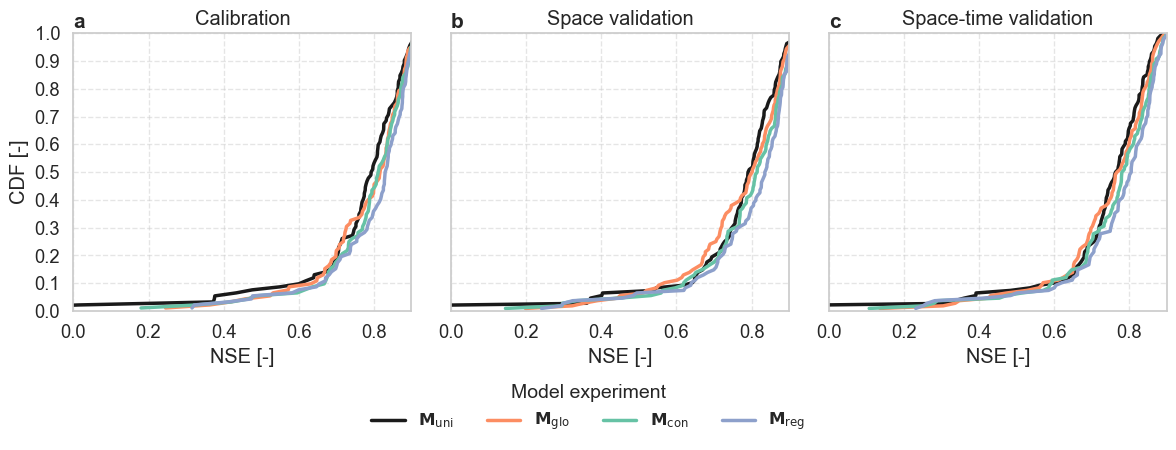

In [184]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

# Plotting function
def plot_cdf_mean(ax, data_input, title, label_letter):
    # Check if input is a dict or DataFrame
    if isinstance(data_input, dict):
        dfs = list(data_input.values())
        all_data = pd.concat(dfs, axis=0)
    elif isinstance(data_input, pd.DataFrame):
        all_data = data_input.copy()
    else:
        raise ValueError("data_input must be a dict of DataFrames or a single DataFrame.")
    
    data_combined = all_data.groupby(all_data.index).mean()

    for model_type in ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']:
        if model_type not in data_combined.columns:
            continue
        nse_values = np.sort(data_combined[model_type].dropna())
        if len(nse_values) == 0:
            continue
        cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
        ax.plot(
            nse_values, cumulative,
            color=colors[model_type],
            linewidth=2.5,
            label=labels_pretty[model_type]
        )

    ax.set_title(title)
    ax.set_xlim(-0.0, 0.9)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("NSE [-]")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

    # Subplot label (a, b, c)
    ax.text(0, 1.075, label_letter, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')


# Set styles
sns.set(style="whitegrid", font_scale=1.2)

# Color and label maps
colors = {
    'nse_nogeo': 'k',
    'nse_g1comp': '#fc8d62',
    'nse_c1comp': '#66c2a5',
    'nse_r1comp': '#8da0cb',
}
labels_pretty = {
    'nse_nogeo': r"$\mathbf{M_{\mathrm{uni}}}$",
    'nse_g1comp': r"$\mathbf{M_{\mathrm{glo}}}$",
    'nse_c1comp': r"$\mathbf{M_{\mathrm{con}}}$",
    'nse_r1comp': r"$\mathbf{M_{\mathrm{reg}}}$",
}

# --- FIGURE 1: CDF plots ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Calibration and space validation use dictionaries
plot_cdf_mean(axs[0], data_diff_calibration_complete_dict_plot, "Calibration", "a")
axs[0].set_ylabel("CDF [-]")

plot_cdf_mean(axs[1], data_diff_cal_complete_dict_plot, "Space validation", "b")

# Space-time validation uses the DataFrame directly
plot_cdf_mean(axs[2], data_diff_val_complete_dict_plot, "Space-time validation", "c")

# Legend shared
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,
           title="Model experiment",
           loc='lower center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=4,
           fontsize=12,
           title_fontsize=14,
           frameon=False)

# Final layout
plt.tight_layout()
plt.savefig(
    "../results/figs/three_cdfs.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


In [142]:
def get_mean_cdf_dataframe(data_input, phase_name):
    # Accept dict of DataFrames or a single DataFrame
    if isinstance(data_input, dict):
        dfs = list(data_input.values())
        all_data = pd.concat(dfs, axis=0)
    elif isinstance(data_input, pd.DataFrame):
        all_data = data_input.copy()
    else:
        raise ValueError("data_input must be a dict of DataFrames or a single DataFrame.")

    data_combined = all_data.groupby(all_data.index).mean()

    cdf_dict = {}
    for model_type in ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']:
        if model_type not in data_combined.columns:
            continue
        nse_values = np.sort(data_combined[model_type].dropna())
        if len(nse_values) == 0:
            continue
        cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
        df_model = pd.DataFrame({
            'NSE': nse_values,
            'CDF': cumulative
        })
        cdf_dict[model_type] = df_model

    return pd.concat(cdf_dict, names=["Model"])


In [ ]:
cdf_cal = get_mean_cdf_dataframe(data_diff_calibration_complete_dict_plot, "Calibration")
cdf_val = get_mean_cdf_dataframe(data_diff_cal_complete_dict_plot, "Space validation")
cdf_valst = get_mean_cdf_dataframe(data_diff_val_complete_dict_plot, "Space-time validation")

In [309]:
cdf_cal.loc["nse_nogeo"][cdf_cal.loc["nse_nogeo"].CDF > 0.5].head(1)

NSE      CDF
46  0.796754  0.51087

In [147]:
print(cdf_val.loc["nse_nogeo"][cdf_val.loc["nse_nogeo"].CDF > 0.5].head(1))
print(cdf_val.loc["nse_g1comp"][cdf_val.loc["nse_g1comp"].CDF > 0.5].head(1))
print(cdf_val.loc["nse_c1comp"][cdf_val.loc["nse_c1comp"].CDF > 0.5].head(1))
print(cdf_val.loc["nse_r1comp"][cdf_val.loc["nse_r1comp"].CDF > 0.5].head(1))

         NSE       CDF
54  0.793668  0.509259
         NSE       CDF
54  0.802393  0.509259
         NSE       CDF
54  0.814945  0.509259
        NSE       CDF
54  0.83843  0.509259


In [150]:
print(cdf_valst.loc["nse_nogeo"][cdf_valst.loc["nse_nogeo"].CDF > 0.5].head(1))
print(cdf_valst.loc["nse_g1comp"][cdf_valst.loc["nse_g1comp"].CDF > 0.5].head(1))
print(cdf_valst.loc["nse_c1comp"][cdf_valst.loc["nse_c1comp"].CDF > 0.5].head(1))
print(cdf_valst.loc["nse_r1comp"][cdf_valst.loc["nse_r1comp"].CDF > 0.5].head(1))

         NSE       CDF
54  0.769815  0.509259
         NSE       CDF
54  0.775153  0.509259
         NSE       CDF
54  0.786662  0.509259
         NSE       CDF
54  0.805361  0.509259


In [152]:
print(cdf_val.loc["nse_nogeo"][cdf_val.loc["nse_nogeo"].CDF > 0.3].head(1))
print(cdf_val.loc["nse_g1comp"][cdf_val.loc["nse_g1comp"].CDF > 0.3].head(1))
print(cdf_val.loc["nse_c1comp"][cdf_val.loc["nse_c1comp"].CDF > 0.3].head(1))
print(cdf_val.loc["nse_r1comp"][cdf_val.loc["nse_r1comp"].CDF > 0.3].head(1))

         NSE       CDF
32  0.750777  0.305556
         NSE       CDF
32  0.721059  0.305556
         NSE       CDF
32  0.766328  0.305556
         NSE       CDF
32  0.771125  0.305556


In [167]:
len(data_diff_cal_complete[data_diff_cal_complete["nse_g1comp"] - data_diff_cal_complete["nse_nogeo"]>=0])

67

In [168]:
len(data_diff_val_complete[data_diff_val_complete["nse_g1comp"] - data_diff_val_complete["nse_nogeo"]>=0])

68

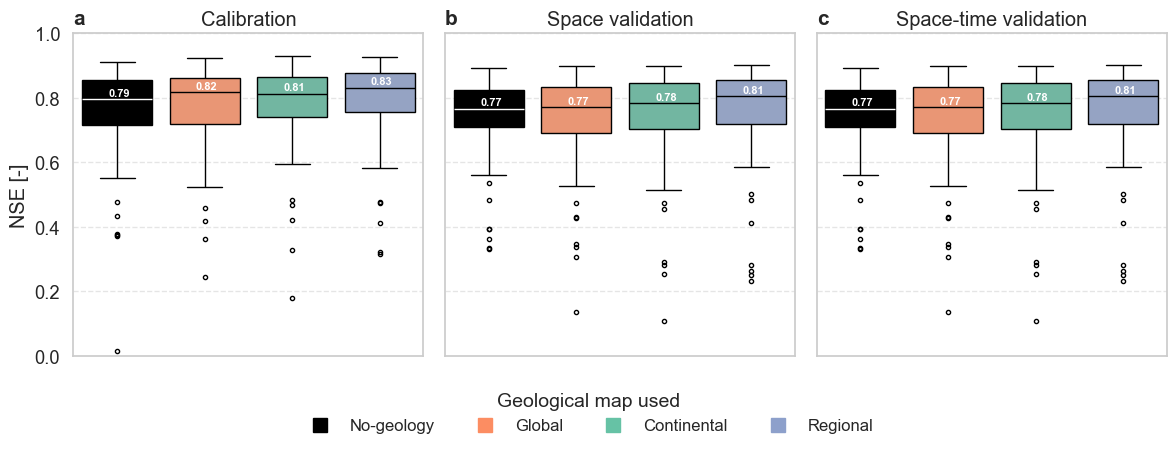

In [310]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines

# Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Model labels and colors
column_label_map = {
    'nse_nogeo': 'No-Geology',
    'nse_g1comp': 'Global',
    'nse_c1comp': 'Continental',
    'nse_r1comp': 'Regional'
}
colors_box = {
    'No-Geology': 'black',
    'Global': '#fc8d62',
    'Continental': '#66c2a5',
    'Regional': '#8da0cb'
}

# Your input DataFrames for the three cases
dataframes = [
    data_diff_calibration_complete,
    data_diff_cal_complete,
    data_diff_val_complete
]
titles = ['Calibration', 'Space validation', 'Space-time validation']
subplot_labels = ['a', 'b', 'c']

# Create tidy DataFrames for seaborn
tidy_dataframes = []
for df, name in zip(dataframes, titles):
    df_tidy = pd.DataFrame({
        'NSE': pd.concat([df[col] for col in column_label_map]),
        'Model': sum([[column_label_map[col]] * len(df) for col in column_label_map], []),
        'Validation': name
    })
    tidy_dataframes.append(df_tidy)

df_all = pd.concat(tidy_dataframes, ignore_index=True)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, (ax, title, label) in enumerate(zip(axs, titles, subplot_labels)):
    df_sub = df_all[df_all["Validation"] == title]

    sns.boxplot(
        data=df_sub,
        x="Model",
        y="NSE",
        hue="Model",
        palette=colors_box,
        linewidth=1,
        fliersize=3,
        dodge=False,
        ax=ax
    )

    # Remove auto-generated legend
    if ax.get_legend():
        ax.get_legend().remove()

    # Annotate medians
    median_lines = ax.lines[4::6]
    for line in median_lines:
        y_data, x_data = line.get_xydata().mean(axis=0)
        ax.text(y_data - 0.1, x_data + 0.02, f"{x_data:.2f}", ha='left', va='center',
                fontweight='bold', fontsize=8, color='white')

        model_names = df_sub['Model'].unique()
        model_index = int(round(y_data))
        if model_index < len(model_names) and model_names[model_index] == 'No-Geology':
            line.set_color('white')

    ax.set_title(title)

    if i == 0:
        ax.set_ylabel("NSE [-]")
    else:
        ax.set_ylabel("")
        ax.tick_params(labelleft=False)  # Fully remove y-tick labels for right panels
    
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Subplot label (a, b, c)
    ax.text(-0.0, 1.075, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')

# Custom legend below
custom_handles = [
    mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label='No-geology'),
    mlines.Line2D([], [], color='#fc8d62', marker='s', linestyle='None', markersize=10, label='Global'),
    mlines.Line2D([], [], color='#66c2a5', marker='s', linestyle='None', markersize=10, label='Continental'),
    mlines.Line2D([], [], color='#8da0cb', marker='s', linestyle='None', markersize=10, label='Regional'),
]

fig.legend(
    handles=custom_handles,
    title="Geological map used",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    fontsize=12,
    title_fontsize=14,
    frameon=False
)

plt.tight_layout()
plt.savefig("../results/figs/three_cdfs.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/4259551077.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


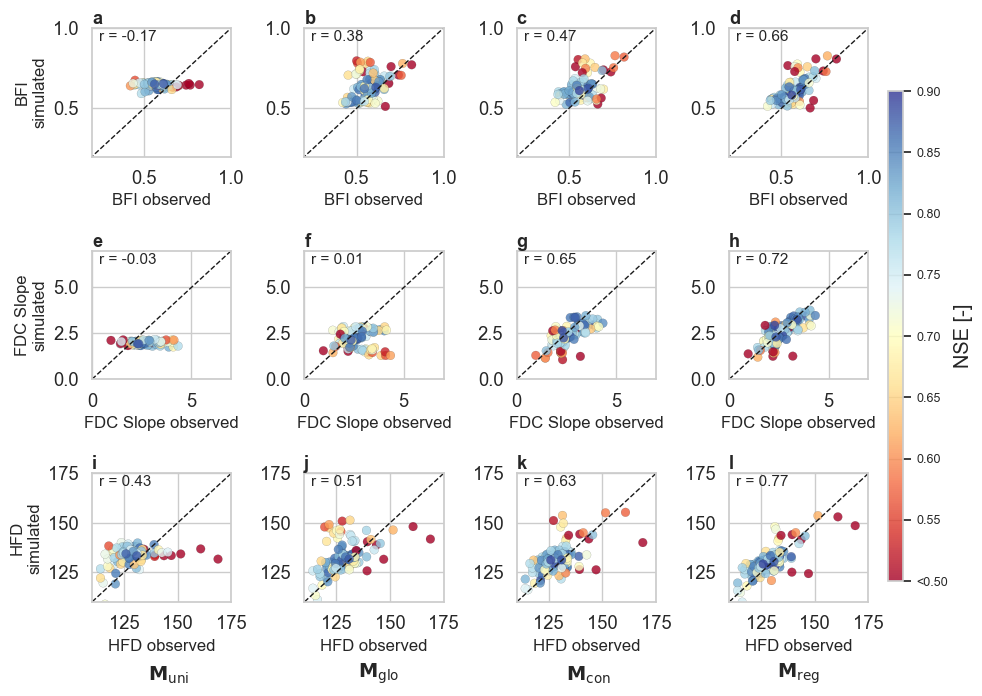

In [311]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define variables and pretty titles
metrics = ['bfi', 'slope', 'hfd']
metric_titles = ['BFI', 'FDC Slope', 'HFD']

# Define suffixes and scales
suffixes = ['nogeo', 'g1comp', 'c1comp', 'r1comp']
scale_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

# Colormap and normalization
cmap = plt.cm.RdYlBu
vmin, vmax = 0.5, 0.9
norm = Normalize(vmin=vmin, vmax=vmax)

# Create subplots
fig, axs = plt.subplots(3, 4, figsize=(10, 7), sharex=False, sharey=False)
letters = list(string.ascii_lowercase)

# For shared colorbar, store one scatter artist
scatter_for_colorbar = None

# Loop through rows and columns
for row, (metric, row_title) in enumerate(zip(metrics, metric_titles)):
    for col, (suffix, scale_title) in enumerate(zip(suffixes, scale_titles)):
        ax = axs[row, col]
        var_obs = f"{metric}_obs"
        var_pred = f"{metric}_{suffix}"
        var_nse = f"nse_{suffix}"

        # Color values clipped to [0.5, 0.9]
        colors = data_diff_val_complete[var_nse].clip(lower=vmin, upper=vmax)

        # Scatterplot
        sc = ax.scatter(
            data_diff_val_complete[var_obs],
            data_diff_val_complete[var_pred],
            c=colors,
            cmap=cmap,
            norm=norm,
            s=40,
            edgecolor='k',
            linewidth=0.1,
            alpha=0.8
        )

        # Store one artist for colorbar
        if scatter_for_colorbar is None:
            scatter_for_colorbar = sc


        # Labels
        if col == 0:
            ax.set_ylabel(f"{row_title}\nsimulated", fontsize=12)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(f"{row_title} observed", fontsize=12)

        # Correlation
        R = data_diff_val_complete[[var_obs, var_pred]].corr(method="pearson").iloc[0, 1]
        ax.text(
            0.05, 0.9, f"r = {R:.2f}", transform=ax.transAxes,
            fontsize=11, bbox=dict(facecolor='none', alpha=0.6, edgecolor='none')
        )

        # Subplot label
        subplot_idx = row * 4 + col
        ax.text(
            -0.00, 1.14, f"{letters[subplot_idx]}", transform=ax.transAxes,
            fontsize=13, fontweight='bold', va='top', ha='left'
        )

        # Set axis limits per metric
        if metric == 'bfi':
            ax.set_xlim(0.2, 1)
            ax.set_ylim(0.2, 1)
        elif metric == 'slope':
            ax.set_xlim(0, 7)
            ax.set_ylim(0, 7)
        elif metric == 'hfd':
            ax.set_xlim(110, 175)
            ax.set_ylim(110, 175)

axs[0, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 1].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 2].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 3].plot([0, 1], [0, 1], 'k--', lw=1)

axs[1, 0].plot([0, 7], [0, 7], 'k--', lw=1)
axs[1, 1].plot([0, 7], [0, 7], 'k--', lw=1)
axs[1, 2].plot([0, 7], [0, 7], 'k--', lw=1)
axs[1, 3].plot([0, 7], [0, 7], 'k--', lw=1)

axs[2, 0].plot([100, 180], [100, 180], 'k--', lw=1)
axs[2, 1].plot([100, 180], [100, 180], 'k--', lw=1)
axs[2, 2].plot([100, 180], [100, 180], 'k--', lw=1)
axs[2, 3].plot([100, 180], [100, 180], 'k--', lw=1)


# Add single vertical colorbar to the right
fig.subplots_adjust(right=0.88)  # Make room for colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter_for_colorbar, cax=cbar_ax)
cbar.set_label("NSE [-]")
cbar.ax.tick_params(labelsize=9)



# Custom ticks and labels
ticks = np.linspace(0.5, 0.9, num=9)  # Adjust number of ticks if needed
tick_labels = [f"<0.50"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.90"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

# Column titles (below x-axis)
col_positions = [0.18, 0.39, 0.6, 0.81]
for x, title in zip(col_positions, scale_titles):
    fig.text(x, 0, title, ha='center', va='bottom', fontsize=14, fontweight='bold')

# Final layout
plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.88)

# Optional save
plt.savefig("../results/figs/signatures_colorbar.png", dpi=300)

plt.show()

In [195]:
data_diff_val_complete[data_diff_val_complete.slope_g1comp < 2.5][data_diff_val_complete.slope_obs > 3]

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/1791010137.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_diff_val_complete[data_diff_val_complete.slope_g1comp < 2.5][data_diff_val_complete.slope_obs > 3]


nse_nogeo  nse_g1comp  nse_c1comp  nse_r1comp   bfi_obs  bfi_r1comp  \
LU000001   0.818454    0.649280    0.881554    0.884523  0.549832    0.543200   
FR000185   0.360620    0.304650    0.253292    0.261731  0.537419    0.771846   
DERP2004   0.780371    0.697834    0.847188    0.854621  0.500677    0.561742   
FR000124   0.772476    0.753625    0.811396    0.807491  0.484187    0.522532   
BEWA0067   0.729356    0.660304    0.793928    0.817378  0.451975    0.551294   
LU000008   0.687396    0.559989    0.719317    0.716055  0.506018    0.543964   
LU000005   0.802608    0.704688    0.852507    0.865122  0.516618    0.561979   
BEWA0106   0.712345    0.527460    0.794958    0.805361  0.500697    0.553869   
DERP2031   0.815352    0.761942    0.844691    0.845447  0.589874    0.568903   
LU000011   0.813974    0.651633    0.865808    0.864817  0.565311    0.565904   
BEWA0107   0.719270    0.566720    0.767076    0.761582  0.579033    0.563482   
BEWA0119   0.779970    0.667152    0.835026    0.844783  0.516294    0.560761   
LU000019   0.789412    0.722665    0.835618    0.849286  0.495707    0.562466   
LU000015   0.774934    0.611168    0.840034    0.849452  0.522385    0.553755   
BEWA0066   0.799494    0.685602    0.865810    0.878786  0.518846    0.560013   

          bfi_c1comp  bfi_g1comp  bfi_nogeo     hfd_obs  ...  slope_obs  \
LU000001    0.574273    0.782482   0.638770  121.500000  ...   3.860265   
FR000185    0.765778    0.733329   0.644075  139.428571  ...   3.200160   
DERP2004    0.587207    0.713699   0.649224  125.480000  ...   3.098546   
FR000124    0.525490    0.621379   0.596098  114.000000  ...   3.097078   
BEWA0067    0.578556    0.695457   0.639020  123.733333  ...   3.529336   
LU000008    0.575109    0.783551   0.640208  119.500000  ...   4.085803   
LU000005    0.586650    0.733425   0.648080  125.166667  ...   3.044633   
BEWA0106    0.587887    0.793989   0.653594  127.695652  ...   4.063630   
DERP2031    0.565357    0.720148   0.632464  133.640000  ...   3.030520   
LU000011    0.591474    0.794881   0.656690  131.333333  ...   3.247142   
BEWA0107    0.588109    0.790302   0.647687  127.086957  ...   3.418620   
BEWA0119    0.586426    0.735354   0.647656  120.409091  ...   3.335934   
LU000019    0.587338    0.709194   0.649611  126.416667  ...   3.429158   
LU000015    0.582595    0.788786   0.647896  121.583333  ...   4.331441   
BEWA0066    0.586049    0.738174   0.647146  126.562500  ...   3.400558   

          slope_r1comp  slope_c1comp  slope_g1comp  slope_nogeo  qmean_obs  \
LU000001      3.581864      3.109574      1.340480     1.877873   1.192096   
FR000185      1.338674      1.316292      1.588988     1.954331   0.799352   
DERP2004      3.368437      3.074827      1.651324     1.960362   1.212305   
FR000124      2.873278      2.531944      2.297750     1.840529   3.916104   
BEWA0067      3.314105      2.987025      1.636624     1.937895   1.521927   
LU000008      3.629050      3.139504      1.359124     1.887828   1.140708   
LU000005      3.320812      3.043438      1.575259     1.951596   1.216879   
BEWA0106      3.758909      3.275390      1.486719     2.017512   1.157128   
DERP2031      3.077905      3.399647      1.629237     2.033145   1.110597   
LU000011      3.604373      3.242003      1.428776     1.958154   0.986891   
BEWA0107      3.130403      2.966732      1.378064     1.937272   1.269441   
BEWA0119      3.312778      3.026627      1.558385     1.951935   1.299843   
LU000019      3.378042      3.104822      1.667025     1.968049   1.178308   
LU000015      3.619007      3.182274      1.379809     1.917866   1.074052   
BEWA0066      3.307116      3.008917      1.551416     1.951208   1.358803   

          qmean_r1comp  qmean_c1comp  qmean_g1comp  qmean_nogeo  
LU000001      1.268308      1.264427      1.230602     1.236307  
FR000185      1.127797      1.124773      1.129408     1.130152  
DERP2004      1.298889      1.295819      1.267811     1.268332  

In [320]:
estreams_attributes_clipped_filters.index.sort_values()[80:100]

Index(['FR003271', 'FR003272', 'FR003274', 'FR003275', 'FR003280', 'FR003283',
       'FR003284', 'FR003288', 'FR003293', 'FR003294', 'FR003295', 'FR003296',
       'FR003300', 'FR003301', 'FR003302', 'FR003307', 'LU000001', 'LU000002',
       'LU000005', 'LU000006'],
      dtype='object', name='basin_id')

In [196]:
data_diff_val_complete[data_diff_val_complete.slope_g1comp > 2.5][data_diff_val_complete.slope_obs < 3].corr()["slope_obs"]["slope_g1comp"]

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/141275162.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_diff_val_complete[data_diff_val_complete.slope_g1comp > 2.5][data_diff_val_complete.slope_obs < 3].corr()["slope_obs"]["slope_g1comp"]


0.22050313729436197

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/1190597904.py:58: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_geometry = FR_selected_gdf.unary_union
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/1190597904.py:64: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  GLiM_moselle_dissolved.plot(column='permeability', ax=ax1, legend=True,
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/1190597904.py:91: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_median_moselle_dissolved.plot(column='permeability', ax=ax2, legend=True,
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/1190597904.py:114: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_high_moselle_dissolved.plot(column='permeability', ax=ax3, legend=True,


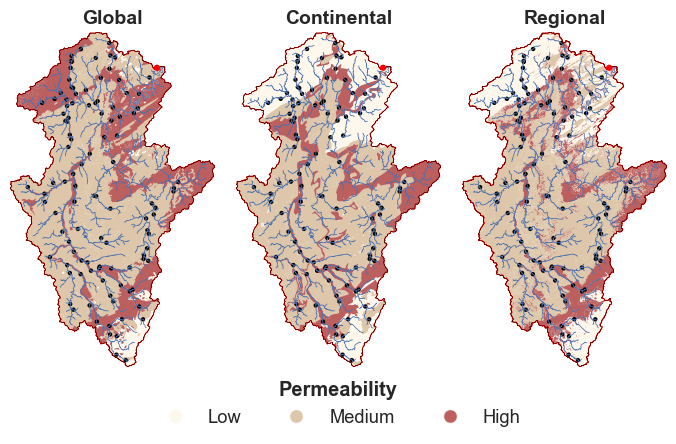

In [197]:
network_estreams_gdf = estreams_attributes_clipped_filters.loc[~estreams_attributes_clipped_filters.index.duplicated(keep='first')]

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_gdf['lon'], network_estreams_gdf['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_gdf, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_gdf.index
# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 4))  # Two subplots side by side

# Select multiple geometries
FR_selected_gdf = moselle.copy()

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'tan',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plot the first geology shapefile with different colors for each class
GLiM_moselle_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax1, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)

# Plot the mask to cover everything outside the study area
#mask.plot(ax=ax1, facecolor='white', edgecolor='red', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_xlabel('')
ax1.set_ylabel('')



# Plot the second geology shapefile with different colors for each class
geology_median_moselle_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax2, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)
# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(c)', loc="left")
ax2.set_xlabel('')
ax2.set_ylabel('')
custom_label = ["Low", "Medium-low", "Medium-high", "High"]

# Plot the third geology shapefile with different colors for each class
geology_high_moselle_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='red', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax3, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)


# Plot the river
rivers_moselle.plot(ax=ax1, linewidth=0.5, label='River network')
rivers_moselle.plot(ax=ax2, linewidth=0.5, label='River network')
rivers_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='red', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(d)', loc="left")

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Overlay the study area boundaries
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25, label='Sub-catchments')

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    #ax.text(0.45, 1.075, text_to_subplots[i], transform=ax.transAxes, 
    #        fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    ax.set_title(text_to_subplots[i], loc="center", fontsize=14, fontweight="bold")
    i = i + 1

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.75),
    'Medium': to_rgba('tan', 0.75),
    'High': to_rgba('brown', 0.75)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')

# Adjust the layout to remove extra space
plt.tight_layout()

fig.savefig("../results/figs/fig_geologies.png", dpi=300, bbox_inches='tight')

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_8339/219378115.py:86: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_8339/219378115.py:88: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_8339/219378115.py:90: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_8339/219378115.py:162: UserWa

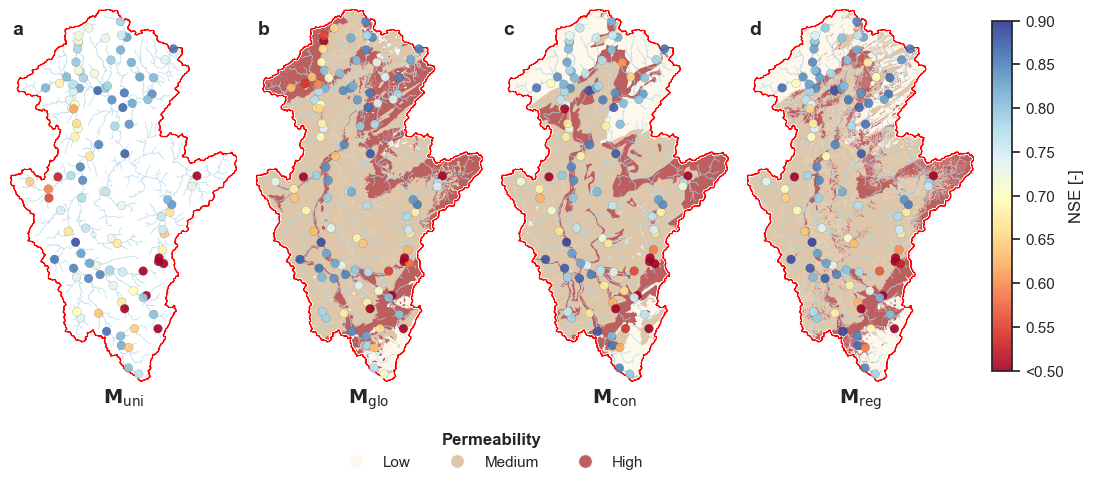

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines


network_estreams_gdf = estreams_attributes_clipped_filters.loc[~estreams_attributes_clipped_filters.index.duplicated(keep='first')]

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_gdf['lon'], network_estreams_gdf['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_gdf, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_gdf.index

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'tan',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set style
sns.set_theme(style="ticks")

# Copy and add coordinates
df = data_diff_val_complete.copy()
df[["lat", "lon"]] = network_estreams[["lat", "lon"]]

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)

# NSE columns and titles
nse_cols = ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']
titles = ['a', 'b', 'c', 'd']
main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

background_maps = ['none', 'GLiM', 'median', 'high']

# Set plot limits to the bounding box of the selected study areas
FR_selected_gdf = moselle.copy()
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

## Create a mask that covers the entire plotting area
#plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
#mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Color setup
vmin, vmax = 0.5, 0.9
cmap_nse = plt.cm.RdYlBu

# Plot loop
for ax, col, subtitle, maintitle, bg_type in zip(axes, nse_cols, titles, main_titles, background_maps):

    # Add background geology map where appropriate
    if bg_type == 'GLiM':
        GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'median':
        geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'high':
        geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

    # Add rivers and boundary for all
    moselle.plot(ax=ax, color='none', linewidth=2, alpha=1)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

#   if bg_type != 'none':
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25)
    mask.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.75)

    # Scatter NSE values
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        vmin=vmin,
        vmax=vmax,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    # Subplot letter
    ax.text(0.01, 0.97, subtitle, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Clean look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(maintitle, fontsize=14, fontweight='bold')
    ax.set_ylabel("")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Colorbar setup
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('NSE [-]')
ticks = np.linspace(0.5, 0.9, num=9)
tick_labels = [f"<0.50"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.90"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.75),
    'Medium': to_rgba('tan', 0.75),
    'High': to_rgba('brown', 0.75)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')

# Save and show
plt.tight_layout()

# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/fig_4geomaps_old.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

In [199]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp<=0.55].loc[:, ["nse_r1comp", "nse_c1comp", "nse_g1comp", "nse_nogeo"]]

nse_r1comp  nse_c1comp  nse_g1comp  nse_nogeo
FR000183    0.483997    0.472558    0.473750   0.391630
FR000185    0.261731    0.253292    0.304650   0.360620
FR000144    0.250477    0.107801    0.136366  -0.190943
FR003280    0.410790    0.453967    0.431325   0.535879
DERP2013    0.500465    0.571146    0.336643  -0.454676
FR003259    0.282321    0.289515    0.347609   0.329937
FR003250    0.231655    0.280377    0.425633   0.392146

In [200]:
catchment_boundaries_moselle = catchment_boundaries.loc[network_estreams_gdf.index.tolist(), :]

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2316751525.py:89: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2316751525.py:91: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2316751525.py:93: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2316751525.py:179

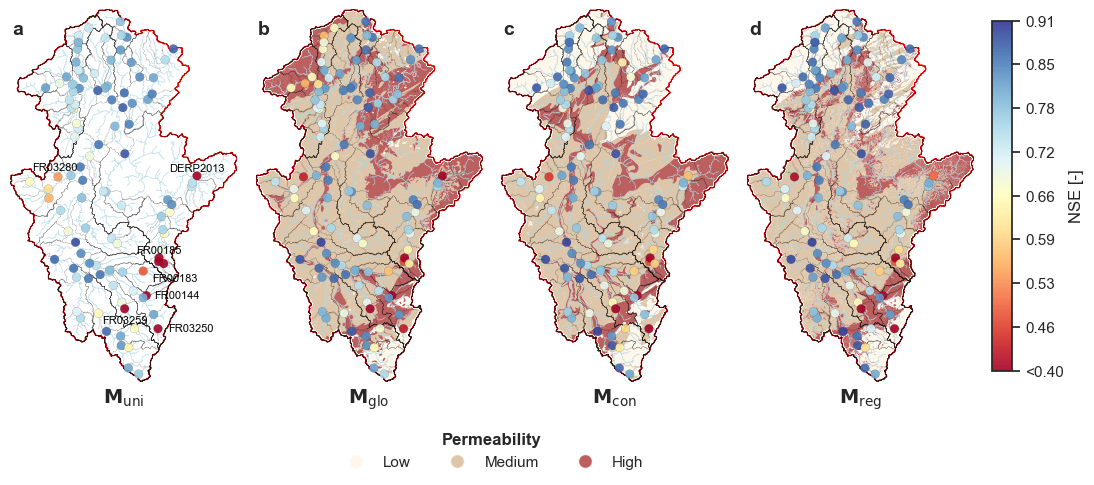

In [271]:
selected_ids = ["DERP2013", "FR000144", "FR000183", "FR000185", "FR003250", "FR003259","FR003280"]


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines


network_estreams_gdf = estreams_attributes_clipped_filters.loc[~estreams_attributes_clipped_filters.index.duplicated(keep='first')]

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_gdf['lon'], network_estreams_gdf['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_gdf, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_gdf.index

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'tan',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set style
sns.set_theme(style="ticks")

# Copy and add coordinates
df = data_diff_val_complete.copy()
df[["lat", "lon"]] = network_estreams[["lat", "lon"]]

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)

# NSE columns and titles
nse_cols = ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']
titles = ['a', 'b', 'c', 'd']
main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

background_maps = ['none', 'GLiM', 'median', 'high']

# Set plot limits to the bounding box of the selected study areas
FR_selected_gdf = moselle.copy()
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

## Create a mask that covers the entire plotting area
#plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
#mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Color setup
vmin, vmax = 0.4, 0.91
cmap_nse = plt.cm.RdYlBu

# Plot loop
for ax, col, subtitle, maintitle, bg_type in zip(axes, nse_cols, titles, main_titles, background_maps):

    # Add background geology map where appropriate
    if bg_type == 'GLiM':
        GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'median':
        geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'high':
        geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

    # Add rivers and boundary for all
    moselle.plot(ax=ax, color='none', linewidth=2, alpha=1)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

#   if bg_type != 'none':
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25)
    mask.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.75)

    # Scatter NSE values
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        vmin=vmin,
        vmax=vmax,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    # Subplot letter
    ax.text(0.01, 0.97, subtitle, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Clean look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(maintitle, fontsize=14, fontweight='bold')
    ax.set_ylabel("")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)


    catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1, label='Sub-catchments')



# Colorbar setup
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('NSE [-]')
ticks = np.linspace(0.4, 0.91, num=9)
tick_labels = [f"<0.40"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.91"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.75),
    'Medium': to_rgba('tan', 0.75),
    'High': to_rgba('brown', 0.75)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')


axes[0].text(7.419000,49.27, "DERP2013", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.014472,48.7, "FR00185", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.18,48.5, "FR00183", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.2,48.38, "FR00144", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.35,48.15, "FR03250", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(6.645964,48.21, "FR03259", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(5.9,49.28, "FR03280", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
	
# Save and show
plt.tight_layout()

# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/fig_4geomaps.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

In [202]:
network_estreams_gdf.loc[["DERP2013", "FR000144", "FR000183", "FR000185", "FR003250", "FR003259","FR003280"], ["lon", "lat"]]

lon        lat
basin_id                     
DERP2013  7.419000  49.254000
FR000144  6.877879  48.416320
FR000183  7.008689  48.654579
FR000185  7.014472  48.680322
FR003250  7.002529  48.184730
FR003259  6.645964  48.324169
FR003280  5.933378  49.246953

In [204]:
data_diff_calibration_complete = data_diff_calibration_complete_dict_plot.copy()

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2402717926.py:86: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2402717926.py:88: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2402717926.py:90: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2402717926.py:176

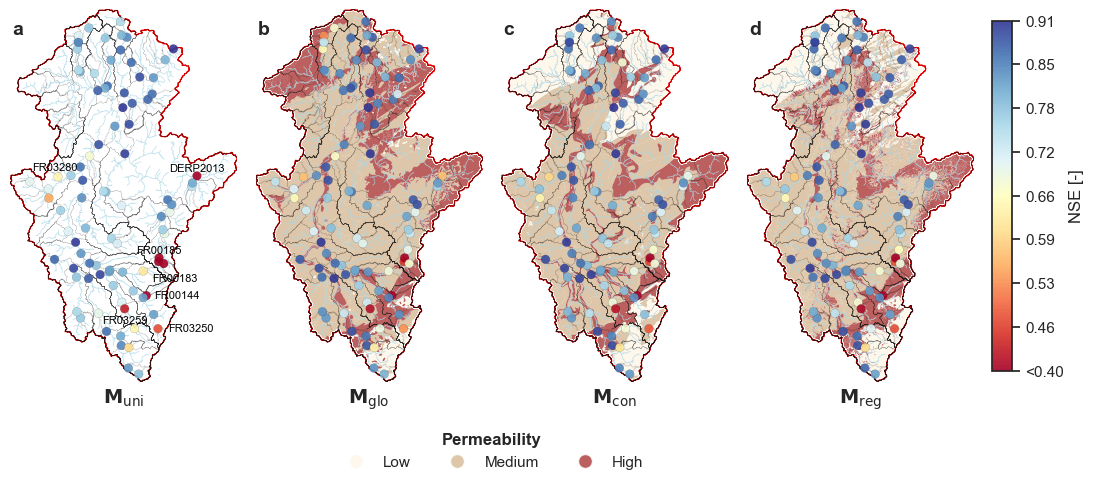

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines


network_estreams_gdf = estreams_attributes_clipped_filters.loc[~estreams_attributes_clipped_filters.index.duplicated(keep='first')]

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_gdf['lon'], network_estreams_gdf['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_gdf, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_gdf.index

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'tan',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set style
sns.set_theme(style="ticks")

# Copy and add coordinates
df = data_diff_calibration_complete.copy()
df[["lat", "lon"]] = network_estreams[["lat", "lon"]]

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)

# NSE columns and titles
nse_cols = ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']
titles = ['a', 'b', 'c', 'd']
main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

background_maps = ['none', 'GLiM', 'median', 'high']

# Set plot limits to the bounding box of the selected study areas
FR_selected_gdf = moselle.copy()
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

## Create a mask that covers the entire plotting area
#plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
#mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Color setup
vmin, vmax = 0.40, 0.91
cmap_nse = plt.cm.RdYlBu

# Plot loop
for ax, col, subtitle, maintitle, bg_type in zip(axes, nse_cols, titles, main_titles, background_maps):

    # Add background geology map where appropriate
    if bg_type == 'GLiM':
        GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'median':
        geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'high':
        geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

    # Add rivers and boundary for all
    moselle.plot(ax=ax, color='none', linewidth=2, alpha=1)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

#   if bg_type != 'none':
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25)
    mask.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.75)

    # Scatter NSE values
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        vmin=vmin,
        vmax=vmax,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    # Subplot letter
    ax.text(0.01, 0.97, subtitle, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Clean look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(maintitle, fontsize=14, fontweight='bold')
    ax.set_ylabel("")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)


    catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1, label='Sub-catchments')



# Colorbar setup
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('NSE [-]')
ticks = np.linspace(0.40, 0.91, num=9)
tick_labels = [f"<0.40"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.91"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.75),
    'Medium': to_rgba('tan', 0.75),
    'High': to_rgba('brown', 0.75)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')


axes[0].text(7.419000,49.27, "DERP2013", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.014472,48.7, "FR00185", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.18,48.5, "FR00183", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.2,48.38, "FR00144", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.35,48.15, "FR03250", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(6.645964,48.21, "FR03259", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(5.9,49.28, "FR03280", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
	
# Save and show
plt.tight_layout()

# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/fig_4geomaps_cal.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

In [206]:
data_diff_cal_complete = data_diff_cal_complete_dict_plot.copy()

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/972619865.py:89: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/972619865.py:91: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/972619865.py:93: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/972619865.py:179: Us

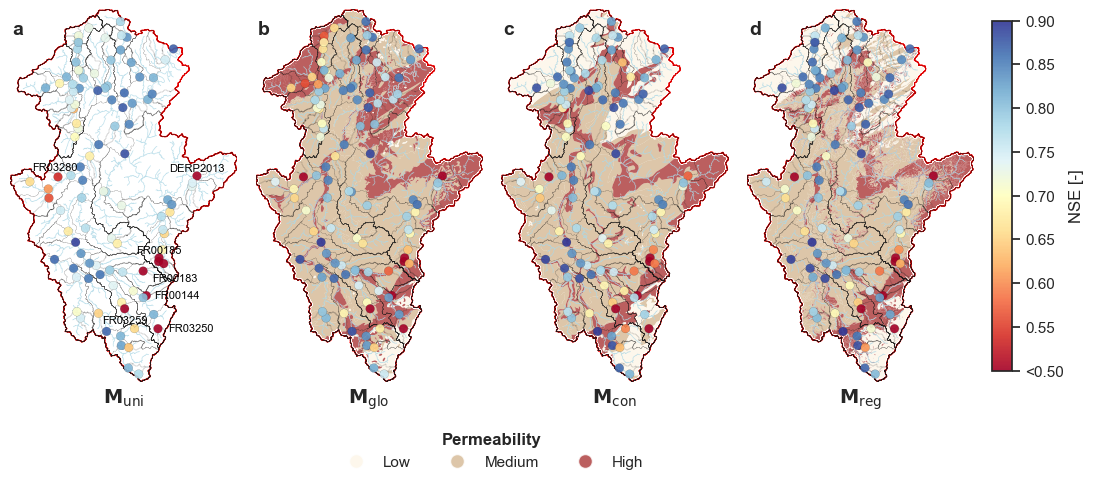

In [207]:
selected_ids = ["DERP2013", "FR000144", "FR000183", "FR000185", "FR003250", "FR003259","FR003280"]


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines


network_estreams_gdf = estreams_attributes_clipped_filters.loc[~estreams_attributes_clipped_filters.index.duplicated(keep='first')]

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_gdf['lon'], network_estreams_gdf['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_gdf, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_gdf.index

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "tan",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'tan',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set style
sns.set_theme(style="ticks")

# Copy and add coordinates
df = data_diff_cal_complete.copy()
df[["lat", "lon"]] = network_estreams[["lat", "lon"]]

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)

# NSE columns and titles
nse_cols = ['nse_nogeo', 'nse_g1comp', 'nse_c1comp', 'nse_r1comp']
titles = ['a', 'b', 'c', 'd']
main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

background_maps = ['none', 'GLiM', 'median', 'high']

# Set plot limits to the bounding box of the selected study areas
FR_selected_gdf = moselle.copy()
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

## Create a mask that covers the entire plotting area
#plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
#mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Color setup
vmin, vmax = 0.5, 0.9
cmap_nse = plt.cm.RdYlBu

# Plot loop
for ax, col, subtitle, maintitle, bg_type in zip(axes, nse_cols, titles, main_titles, background_maps):

    # Add background geology map where appropriate
    if bg_type == 'GLiM':
        GLiM_moselle_dissolved.plot(column='permeability', ax=ax, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'median':
        geology_median_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)
    elif bg_type == 'high':
        geology_high_moselle_dissolved.plot(column='permeability', ax=ax, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

    # Add rivers and boundary for all
    moselle.plot(ax=ax, color='none', linewidth=2, alpha=1)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

#   if bg_type != 'none':
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25)
    mask.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.75)

    # Scatter NSE values
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        vmin=vmin,
        vmax=vmax,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    # Subplot letter
    ax.text(0.01, 0.97, subtitle, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Clean look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(maintitle, fontsize=14, fontweight='bold')
    ax.set_ylabel("")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)


    catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.1, label='Sub-catchments')



# Colorbar setup
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('NSE [-]')
ticks = np.linspace(0.5, 0.9, num=9)
tick_labels = [f"<0.50"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.90"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.75),
    'Medium': to_rgba('tan', 0.75),
    'High': to_rgba('brown', 0.75)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')


axes[0].text(7.419000,49.27, "DERP2013", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.014472,48.7, "FR00185", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.18,48.5, "FR00183", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.2,48.38, "FR00144", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(7.35,48.15, "FR03250", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(6.645964,48.21, "FR03259", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
axes[0].text(5.9,49.28, "FR03280", fontsize=8, ha='center', va='bottom', zorder=20, color='black')
	
# Save and show
plt.tight_layout()

# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/fig_4geomaps_space.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

In [209]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp<0.55][["nse_r1comp", "nse_nogeo"]]

nse_r1comp  nse_nogeo
FR000183    0.483997   0.391630
FR000185    0.261731   0.360620
FR000144    0.250477  -0.190943
FR003280    0.410790   0.535879
DERP2013    0.500465  -0.454676
FR003259    0.282321   0.329937
FR003250    0.231655   0.392146

In [210]:
data_diff_cal_complete[data_diff_cal_complete.nse_r1comp<0.6][["nse_r1comp", "nse_nogeo"]]

nse_r1comp  nse_nogeo
FR000183    0.483997   0.391630
FR000185    0.261731   0.360620
FR000144    0.250477  -0.190943
FR003280    0.410790   0.535879
DERP2013    0.500465  -0.454676
FR003259    0.282321   0.329937
FR003250    0.231655   0.392146
FR003254    0.585302   0.483985

In [211]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp>0.88][["nse_r1comp", "nse_nogeo"]]

nse_r1comp  nse_nogeo
LU000001    0.884523   0.818454
FR003249    0.892924   0.866954
FR000128    0.884267   0.826265
FR003241    0.886049   0.853902
FR003265    0.900366   0.891996
DEBU1957    0.889051   0.882486
FR003237    0.899046   0.867927
FR000140    0.884409   0.858613
DERP2003    0.890121   0.874557

In [212]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp>0.7][["nse_r1comp", "nse_nogeo"]]

nse_r1comp  nse_nogeo
LU000010    0.781314   0.741551
LU000001    0.884523   0.818454
DERP2028    0.700712   0.826222
DERP2008    0.799650   0.724378
FR000137    0.805647   0.747620
...              ...        ...
DERP2007    0.833789   0.797618
FR003271    0.758118   0.769815
FR003301    0.861254   0.836145
DERP2003    0.890121   0.874557
DEBU1958    0.877307   0.876176

[87 rows x 2 columns]

In [259]:
87/108

0.8055555555555556

<Axes: >

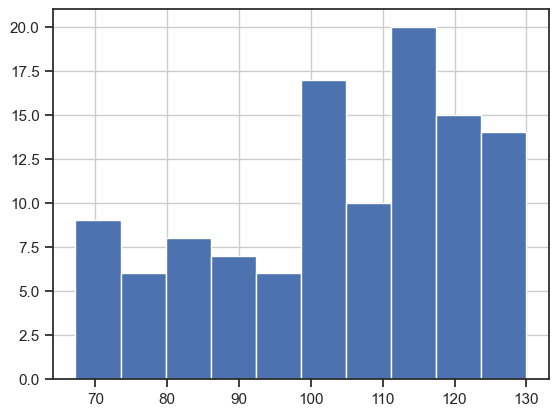

In [215]:
estreams_attributes_clipped_filters.root_dep_mean.hist()

<Axes: >

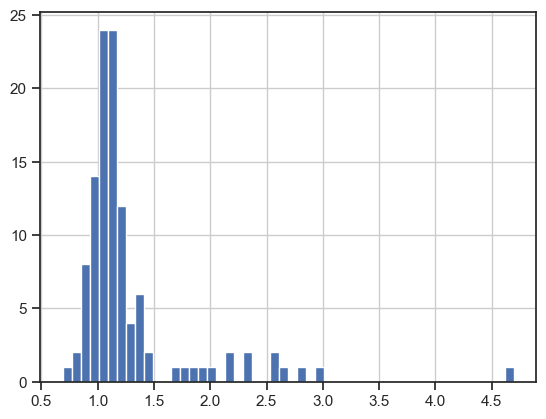

In [274]:
estreams_attributes_clipped_filters.bedrk_dep.hist(bins=50)

In [217]:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.bedrk_dep<0.9]



Unnamed: 0    gauge_id            gauge_name gauge_country  \
basin_id                                                               
FR000183           4  A900105050              A9001050            FR   
FR000124          21  A402061001              A4020610            FR   
FR000125          39  A405062001              A4050620            FR   
FR000184          49  A901305050              A9013050            FR   
FR000184          84  A901305050              A9013050            FR   
FR003250          98  A600101001  La Meurthe Ã  Fraize            FR   
FR000184         111  A901305050              A9013050            FR   

         gauge_provider                                river  lon_snap  \
basin_id                                                                 
FR000183   FR_EAUFRANCE  La Sarre à Laneuveville-lès-Lorquin  7.008689   
FR000124   FR_EAUFRANCE      La Moselle à Fresse-sur-Moselle  6.796285   
FR000125   FR_EAUFRANCE        La Moselle à Rupt-sur-Moselle  6.685918   
FR000184   FR_EAUFRANCE        La Sarre Rouge à Vasperviller  7.060836   
FR000184   FR_EAUFRANCE        La Sarre Rouge à Vasperviller  7.060836   
FR003250   FR_EAUFRANCE                  La Meurthe à Fraize  7.002529   
FR000184   FR_EAUFRANCE        La Sarre Rouge à Vasperviller  7.060836   

           lat_snap       lon        lat  ...  irri_1990  irri_2005  \
basin_id                                  ...                         
FR000183  48.654579  7.008689  48.654579  ...        0.0        0.0   
FR000124  47.866921  6.796285  47.866921  ...        0.0        0.0   
FR000125  47.909445  6.685918  47.909445  ...        0.0        0.0   
FR000184  48.640785  7.064290  48.640085  ...        0.0        0.0   
FR000184  48.640785  7.064290  48.640085  ...        0.0        0.0   
FR003250  48.184730  7.002529  48.184730  ...        0.0        0.0   
FR000184  48.640785  7.064290  48.640085  ...        0.0        0.0   

          stations_num_p_mean  perm_high_regi  perm_medium_regi perm_low_regi  \
basin_id                                                                        
FR000183                  4.0            66.0              29.0           5.0   
FR000124                  9.0             3.0               0.0          97.0   
FR000125                  9.0             7.0               0.0          93.0   
FR000184                  5.0            98.0               2.0           0.0   
FR000184                  5.0            98.0               2.0           0.0   
FR003250                  3.0             4.0               0.0          96.0   
FR000184                  5.0            98.0               2.0           0.0   

         perm_high_glob2  perm_medium_glob2  perm_low_glob2    group  
basin_id                                                              
FR000183            64.0               30.0             6.0  Group_1  
FR000124             0.0               22.0            78.0  Group_2  
FR000125             3.0               18.0            79.0  Group_3  
FR000184            96.0                4.0             0.0  Group_3  
FR000184            96.0                4.0             0.0  Group_6  
FR003250             0.0                6.0            94.0  Group_7  
FR000184            96.0                4.0             0.0  Group_7  

[7 rows x 127 columns]

In [285]:
estreams_attributes.columns[40:]

Index(['lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean', 'aridity',
       'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time', 'lp_freq',
       'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean', 'ele_mt_min',
       'slp_dg_mean', 'flat_area_fra', 'steep_area_fra', 'elon_ratio',
       'strm_dens', 'lit_dom', 'bedrk_dep', 'perm_verylow_glob',
       'perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 'lit_fra_su',
       'lit_fra_ss', 'lit_fra_sm', 'lit_fra_sc', 'lit_fra_mt', 'lit_fra_pi',
       'lit_fra_py', 'lit_fra_vi', 'lit_fra_ev', 'lit_fra_ig', 'lit_fra_pa',
       'lit_fra_pb', 'lit_fra_va', 'lit_fra_vb', 'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont',
       'lit_fra_Conglomerates', 'lit_fra_Conglomerates and sands',
       'lit_fra_Gravels', 'lit_fra_Sands', 'lit_fra_Sandstones',
       'lit_fra_Sandstones and sands', 'root_dep_mean', 'root_dep_max',
       'root_dep_min', 'soil_tawc_mean', 'soil_fra_sand_mean',
       '

In [218]:
estreams_attributes.loc[["DERP2013","FR000144", "FR000184", "FR003234", "FR003250"], ["frac_snow", "sno_cov_mean", "root_dep_mean",'soil_fra_sand_mean',
       'soil_fra_silt_mean', 'soil_fra_clay_mean', 'soil_fra_grav_mean', "bedrk_dep", "hfd_mean"]]


frac_snow  sno_cov_mean  root_dep_mean  soil_fra_sand_mean  \
basin_id                                                               
DERP2013      0.039         3.575        116.881              39.495   
FR000144      0.047         7.244         79.831              76.475   
FR000184      0.044         6.350         85.281              73.202   
FR003234      0.062         9.623         77.463              68.701   
FR003250      0.075        11.555         89.701              73.896   

          soil_fra_silt_mean  soil_fra_clay_mean  soil_fra_grav_mean  \
basin_id                                                               
DERP2013              35.219              25.285               9.293   
FR000144              15.559               7.966               5.483   
FR000184              17.596               9.202               6.326   
FR003234              20.313              10.985               7.343   
FR003250              16.537               9.567               7.597   

          bedrk_dep  hfd_mean  
basin_id                       
DERP2013      1.017   166.582  
FR000144      0.917   172.085  
FR000184      0.885   160.347  
FR003234      0.972   137.188  
FR003250      0.802   156.082

In [ ]:
estreams_attributes.bedrk_dep.describe

count    9340.000000
mean        9.126052
std        12.585211
min         0.429000
25%         1.049000
50%         1.908500
75%        13.019500
max        49.824000
Name: bedrk_dep, dtype: float64

In [290]:


estreams_attributes.sno_cov_mean.describe()

count    9340.000000
mean        7.911011
std         8.514380
min         0.028000
25%         1.730000
50%         5.460500
75%        10.197250
max        59.110000
Name: sno_cov_mean, dtype: float64

In [ ]:
estreams_attributes.loc["FR003250", ["area_estreams"]]

In [64]:
estreams_attributes.loc["FR000183", ["area_estreams"]]

area_estreams    70.75
Name: FR000183, dtype: object

In [220]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp<0.55][["nse_r1comp","nse_g1comp", "nse_nogeo", "bfi_obs", "bfi_r1comp"]]

nse_r1comp  nse_g1comp  nse_nogeo   bfi_obs  bfi_r1comp
FR000183    0.483997    0.473750   0.391630  0.740801    0.732076
FR000185    0.261731    0.304650   0.360620  0.537419    0.771846
FR000144    0.250477    0.136366  -0.190943  0.698369    0.808972
FR003280    0.410790    0.431325   0.535879  0.665425    0.502541
DERP2013    0.500465    0.336643  -0.454676  0.816544    0.807227
FR003259    0.282321    0.347609   0.329937  0.576604    0.726798
FR003250    0.231655    0.425633   0.392146  0.685264    0.549493

In [221]:
len(data_diff_val_complete[data_diff_val_complete.nse_r1comp>0.5])/108

0.9444444444444444

In [222]:
len(data_diff_val_complete[data_diff_val_complete.nse_c1comp>0.5])

102

In [223]:
len(data_diff_val_complete[data_diff_val_complete.nse_g1comp>0.5])

101

In [224]:
len(data_diff_val_complete[data_diff_val_complete.nse_nogeo>0.5])

100

In [225]:
estreams_attributes_clipped_filters

Unnamed: 0    gauge_id            gauge_name gauge_country  \
basin_id                                                               
LU000018           0           5            Schoenfels            LU   
LU000010           1           6             Hunnebuer            LU   
LU000001           2          17            Bigonville            LU   
DERP2028           3  2674030900          Eisenschmitt            DE   
FR000183           4  A900105050              A9001050            FR   
...              ...         ...                   ...           ...   
FR003271         107  A782101001   La Seille Ã  Nomeny            FR   
FR003301         108  A930108040  La Sarre Ã  Wittring            FR   
DERP2003         109  2620050500            Bollendorf            DE   
DEBU1958         110    26500100    BundespegelTrierUp            DE   
FR000184         111  A901305050              A9013050            FR   

          gauge_provider                                river  lon_snap  \
basin_id                                                                  
LU000018  LU_CONTACTFORM                                Mamer  6.100795   
LU000010  LU_CONTACTFORM                                Eisch  6.079524   
LU000001  LU_CONTACTFORM                                 Sure  5.801399   
DERP2028           DE_RP                                 Salm  6.718000   
FR000183    FR_EAUFRANCE  La Sarre à Laneuveville-lès-Lorquin  7.008689   
...                  ...                                  ...       ...   
FR003271    FR_EAUFRANCE                   La Seille à Nomeny  6.227788   
FR003301    FR_EAUFRANCE                  La Sarre à Wittring  7.150066   
DERP2003           DE_RP                                Sauer  6.359000   
DEBU1958           DE_BU                                Mosel  6.627000   
FR000184    FR_EAUFRANCE        La Sarre Rouge à Vasperviller  7.060836   

           lat_snap       lon        lat  ...  irri_1990  irri_2005  \
basin_id                                  ...                         
LU000018  49.723112  6.100795  49.723112  ...      0.015      0.015   
LU000010  49.729184  6.079524  49.729184  ...      0.026      0.026   
LU000001  49.869821  5.801399  49.869821  ...      0.000      0.000   
DERP2028  50.048000  6.718000  50.048000  ...      0.000      0.000   
FR000183  48.654579  7.008689  48.654579  ...      0.000      0.000   
...             ...       ...        ...  ...        ...        ...   
FR003271  48.888271  6.227788  48.888271  ...      0.429      0.436   
FR003301  49.053225  7.150066  49.053225  ...      0.436      2.205   
DERP2003  49.851000  6.359000  49.851000  ...      1.627      4.160   
DEBU1958  49.732000  6.627000  49.732000  ...     10.862     12.761   
FR000184  48.640785  7.064290  48.640085  ...      0.000      0.000   

          stations_num_p_mean  perm_high_regi  perm_medium_regi perm_low_regi  \
basin_id                                                                        
LU000018                 17.0            39.0              61.0           0.0   
LU000010                 16.0            42.0              58.0           0.0   
LU000001                  9.0             1.0               0.0          99.0   
DERP2028                 10.0            80.0               7.0          13.0   
FR000183                  4.0            66.0              29.0           5.0   
...                       ...             ...               ...           ...   
FR003271                  5.0             8.0              92.0           0.0   
FR003301                 16.0            17.0              83.0           0.0   
DERP2003                 65.0            17.0              30.0          53.0   
DEBU1958                219.0            25.0              60.0          15.0   
FR000184                  5.0            98.0               2.0           0.0   

         perm_high_glob2  perm_medium_glob2  perm_low_glob2    group  
basin_id                                        

In [257]:
estreams_attributes_clipped_filters.loc[["DERP2013", "FR003280", "FR003250", "FR000185", "FR003259"]][["root_dep_mean", "perm_low_regi", "perm_high_regi", "perm_high_glob2", "perm_low_glob2"]]

root_dep_mean  perm_low_regi  perm_high_regi  perm_high_glob2  \
basin_id                                                                  
DERP2013        116.881            0.0            91.0             92.0   
FR003280        103.243            0.0             0.0              0.0   
FR003250         89.701           96.0             4.0              0.0   
FR000185         92.353            2.0            75.0             71.0   
FR003259        128.125            0.0            66.0             35.0   

          perm_low_glob2  
basin_id                  
DERP2013             0.0  
FR003280             0.0  
FR003250            94.0  
FR000185             2.0  
FR003259             0.0

In [227]:
len(data_diff_cal_complete[data_diff_cal_complete.nse_r1comp>0.5])/108

0.9444444444444444

In [228]:
data_diff_cal_complete[data_diff_cal_complete.nse_r1comp>0.5].nse_r1comp

LU000018    0.662263
LU000010    0.781314
LU000001    0.884523
DERP2028    0.700712
DERP2008    0.799650
              ...   
DERP2007    0.833789
FR003271    0.758118
FR003301    0.861254
DERP2003    0.890121
DEBU1958    0.877307
Name: nse_r1comp, Length: 102, dtype: float64

In [ ]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp<0.5].nse_r1comp

basin
BEWA0066    0.862221
BEWA0067    0.796874
BEWA0106    0.786910
BEWA0107    0.742823
BEWA0119    0.827949
              ...   
LU000015    0.831037
LU000016    0.678671
LU000017    0.856614
LU000018    0.652775
LU000019    0.831140
Name: nse_r1comp, Length: 101, dtype: float64

In [175]:
network_estreams.loc[data_diff_val_complete[data_diff_val_complete.nse_r1comp<0.5].index.tolist()]


gauge_id                                         gauge_name  \
basin_id                                                                  
DERP2013  2642030800                                            Contwig   
FR000144  A623201001                                           A6232010   
FR000183  A900105050                                           A9001050   
FR000185  A902101060                                           A9021050   
FR003250  A600101001                               La Meurthe Ã  Fraize   
FR003259  A664031002  L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...   
FR003280  A832201001                                 Le Woigot Ã  Briey   

         gauge_country gauge_provider  \
basin_id                                
DERP2013            DE          DE_RP   
FR000144            FR   FR_EAUFRANCE   
FR000183            FR   FR_EAUFRANCE   
FR000185            FR   FR_EAUFRANCE   
FR003250            FR   FR_EAUFRANCE   
FR003259            FR   FR_EAUFRANCE   
FR003280            FR   FR_EAUFRANCE   

                                                 river  lon_snap   lat_snap  \
basin_id                                                                      
DERP2013                                   Schwarzbach  7.419000  49.254000   
FR000144         La Plaine à Raon-l'Étape [La Trouche]  6.877879  48.416320   
FR000183           La Sarre à Laneuveville-lès-Lorquin  7.008689  48.654579   
FR000185                         La Sarre à Hermelange  7.014472  48.680322   
FR003250                           La Meurthe à Fraize  7.002529  48.184730   
FR003259  L'Arentèle à Saint-Gorgon et à Sainte-Hélène  6.645964  48.324169   
FR003280                             Le Woigot à Briey  5.933378  49.246953   

               lon        lat elevation  ...  num_continuous_days  \
basin_id                                 ...                        
DERP2013  7.419000  49.254000       NaN  ...                24532   
FR000144  6.877879  48.416320       290  ...                11494   
FR000183  7.008689  48.654579       268  ...                 5322   
FR000185  7.014472  48.680322       258  ...                 4108   
FR003250  7.002529  48.184730       498  ...                 7524   
FR003259  6.645964  48.324169       295  ...                 4268   
FR003280  5.933378  49.246953       204  ...                15790   

          num_days_gaps  num_days_reliable  num_days_noflag num_days_suspect  \
basin_id                                                                       
DERP2013          101.0                0.0          25162.0              0.0   
FR000144          179.0            19423.0              0.0             29.0   
FR000183          399.0            19568.0             62.0            120.0   
FR000185         1711.0            13759.0              0.0             22.0   
FR003250          192.0            18280.0              0.0            606.0   
FR003259           64.0             6737.0              0.0            275.0   
FR003280           39.0            19517.0            818.0            188.0   

         gauge_flag  duplicated_suspect  watershed_group  gauges_upstream  \
basin_id                                                                    
DERP2013          B                 NaN                1                1   
FR000144          A                 NaN                1                1   
FR000183          A                 NaN                1                1   
FR000185          D          [FR003292]                1                3   
FR003250          A                 NaN                1                1   
FR003259          A                 NaN                1                2   
FR003280          B                 NaN                1                3   

                       nested_catchments  
basin_id                                  
DERP2013                      [DERP2013]  
FR000144                      [FR000144]  
FR000183                      [FR000183]  
FR

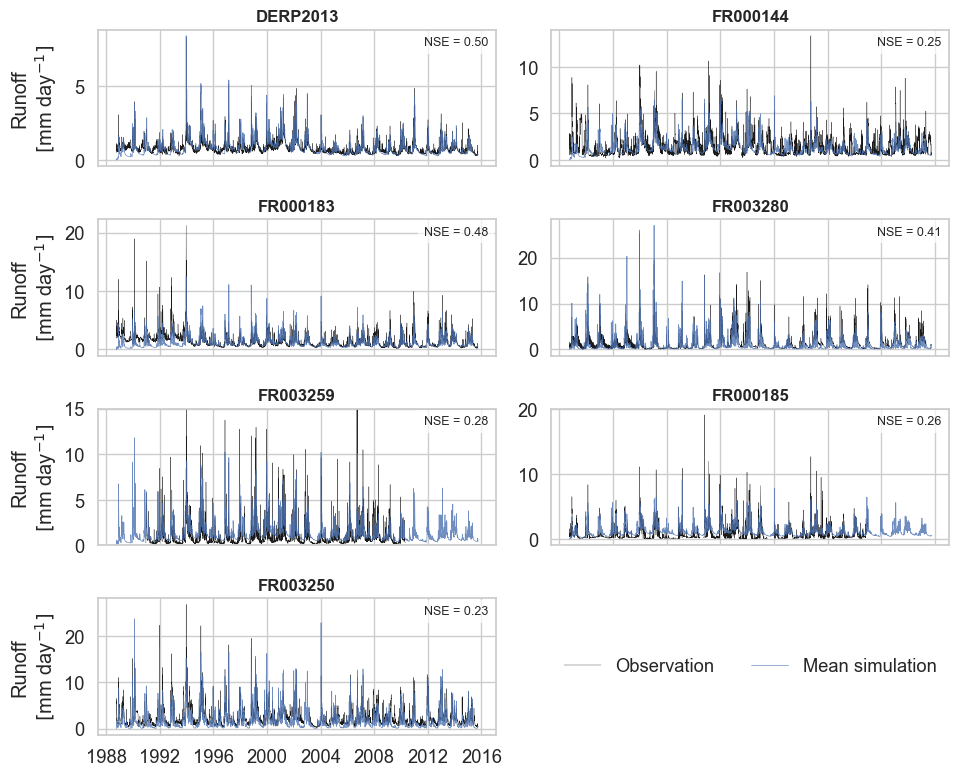

In [384]:
import matplotlib.pyplot as plt

# Define parameters
gauge_ids = ["DERP2013", "FR000144", "FR000183", "FR003280", "FR003259", "FR000185","FR003250"]  # Your 6 gauge IDs
start_date = "1988-10-01"
end_date = "2015-09-30"

# Create subplots (2 columns × 3 rows)
fig, axes = plt.subplots(4, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()  # Flatten to easily loop

# Plot each hydrograph
for i, gauge_id in enumerate(gauge_ids):
    ax = axes[i]
    
    # Subset the dataset for this gauge and time range
    ts = ds_mean.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    # Plot observation and regional simulation
    ax.plot(ts.date, ts["observation"], label="Observation", linewidth=0.25, color="k")
    ax.plot(ts.date, ts["regional"], label="Regional", linewidth=0.5, alpha=0.8)
    
    ax.set_title(f"{gauge_id}", fontsize=12, fontweight="bold")
    #ax.set_ylim(0, 20)
    ax.grid(True)

    if i % 2 == 0:  # Left column
        ax.set_ylabel("Runoff\n$[$mm day$^{-1}]$")

    # Get NSE value (rounded for display)
    nse = data_diff_val_complete.loc[gauge_id, "nse_r1comp"]
    nse_label = f"NSE = {nse:.2f}"
    
    # Add NSE label inside the plot (top-right corner)
    ax.text(
        0.98, 0.95, nse_label,
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=9,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

    #if i == 5:
    #    ax.set_xticklabels(["1990", "1992", "1994", "1996", "1998", "2000"])



#axes[0].set_ylim(0, 10)
#axes[1].set_ylim(0, 10)
axes[4].set_ylim(0, 15)


main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

# Use last subplot for legend
legend_ax = axes[-1]
legend_ax.axis("off")

# Custom legend
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Observation", r"Mean simulation"]

legend_ax.legend(
    handles, labels,
    loc="center",
    frameon=False,
    ncol=3
)


fig.align_ylabels(axes)

plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for legend


# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/hydrographs_badNSE.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

In [ ]:
# Parameters
gauge_ids = ["DERP2013", "FR000144", "FR000183", "FR003280", "FR003259", "FR000185", "FR003250"]
start_date = "1995-10-01"
end_date = "2015-09-30"

# Compute and print NSEE per gauge
for gauge_id in gauge_ids:
    # Subset the dataset for this gauge and time range
    ts = ds_mean.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))

    # Observations and regional simulation
    observations = ts["observation"].values
    simulation = ts["regional"].values

    # Compute NSEE
    nsee_value = compute_nse(observations, simulation)

    # Print result
    print(f"{gauge_id}: NSEE = {nsee_value:.3f}")


DERP2013: NSEE = 0.609
FR000144: NSEE = 0.122
FR000183: NSEE = 0.776
FR003280: NSEE = 0.464
FR003259: NSEE = 0.205
FR000185: NSEE = 0.333
FR003250: NSEE = 0.174


In [258]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp<0.55][["nse_r1comp","nse_c1comp", "nse_g1comp", "nse_nogeo", "bfi_obs", "bfi_r1comp"]]

nse_r1comp  nse_c1comp  nse_g1comp  nse_nogeo   bfi_obs  bfi_r1comp
FR000183    0.483997    0.472558    0.473750   0.391630  0.740801    0.732076
FR000185    0.261731    0.253292    0.304650   0.360620  0.537419    0.771846
FR000144    0.250477    0.107801    0.136366  -0.190943  0.698369    0.808972
FR003280    0.410790    0.453967    0.431325   0.535879  0.665425    0.502541
DERP2013    0.500465    0.571146    0.336643  -0.454676  0.816544    0.807227
FR003259    0.282321    0.289515    0.347609   0.329937  0.576604    0.726798
FR003250    0.231655    0.280377    0.425633   0.392146  0.685264    0.549493

In [377]:
data_diff_val_complete[data_diff_val_complete.nse_r1comp>0.88][["nse_r1comp","nse_c1comp", "nse_g1comp", "nse_nogeo", "bfi_obs", "bfi_r1comp"]]

nse_r1comp  nse_c1comp  nse_g1comp  nse_nogeo   bfi_obs  bfi_r1comp
LU000001    0.884523    0.881554    0.649280   0.818454  0.549832    0.541392
FR003249    0.892924    0.891078    0.884859   0.866954  0.581528    0.602991
FR000128    0.884267    0.880618    0.832449   0.826265  0.526895    0.551680
FR003241    0.886049    0.884207    0.866354   0.853902  0.575086    0.600708
FR003265    0.900366    0.899369    0.897081   0.891996  0.605153    0.632555
DEBU1957    0.889051    0.888017    0.889836   0.882486  0.607290    0.629697
FR003237    0.899046    0.896788    0.879130   0.867927  0.583372    0.596317
FR000140    0.884409    0.883873    0.872127   0.858613  0.570017    0.604185
DERP2003    0.890121    0.889400    0.851956   0.874557  0.560047    0.582378

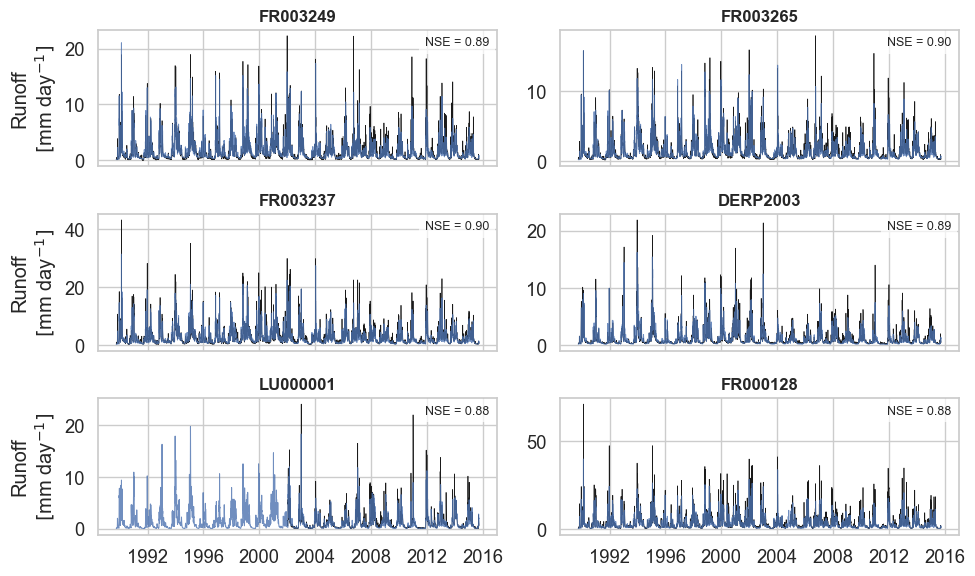

In [380]:
import matplotlib.pyplot as plt

# Define parameters
gauge_ids = ["FR003249", "FR003265", "FR003237", "DERP2003", "LU000001", "FR000128"]  # Your 6 gauge IDs
start_date = "1989-10-01"
end_date = "2015-09-30"

# Create subplots (2 columns × 3 rows)
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()  # Flatten to easily loop

# Plot each hydrograph
for i, gauge_id in enumerate(gauge_ids):
    ax = axes[i]
    
    # Subset the dataset for this gauge and time range
    ts = ds_mean.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    # Plot observation and regional simulation
    ax.plot(ts.date, ts["observation"], label="Observation", linewidth=0.5, color="k")
    ax.plot(ts.date, ts["regional"], label="Regional", linewidth=0.75, alpha=0.8)
    
    ax.set_title(f"{gauge_id}", fontsize=12, fontweight="bold")
    #ax.set_ylim(0, 20)
    ax.grid(True)

    if i % 2 == 0:  # Left column
        ax.set_ylabel("Runoff\n$[$mm day$^{-1}]$")

    # Get NSE value (rounded for display)
    nse = data_diff_val_complete.loc[gauge_id, "nse_r1comp"]
    nse_label = f"NSE = {nse:.2f}"
    
    # Add NSE label inside the plot (top-right corner)
    ax.text(
        0.98, 0.95, nse_label,
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=9,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

    #if i == 5:
    #    ax.set_xticklabels(["1990", "1992", "1994", "1996", "1998", "2000"])



#axes[0].set_ylim(0, 10)
#axes[1].set_ylim(0, 10)


main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

# Use last subplot for legend
#legend_ax = axes[-1]
#legend_ax.axis("off")

# Custom legend
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Observation", r"Mean simulation"]

legend_ax.legend(
    handles, labels,
    loc="center",
    frameon=False,
    ncol=3
)


fig.align_ylabels(axes)

plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for legend


# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/hydrographs_goodNSE.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

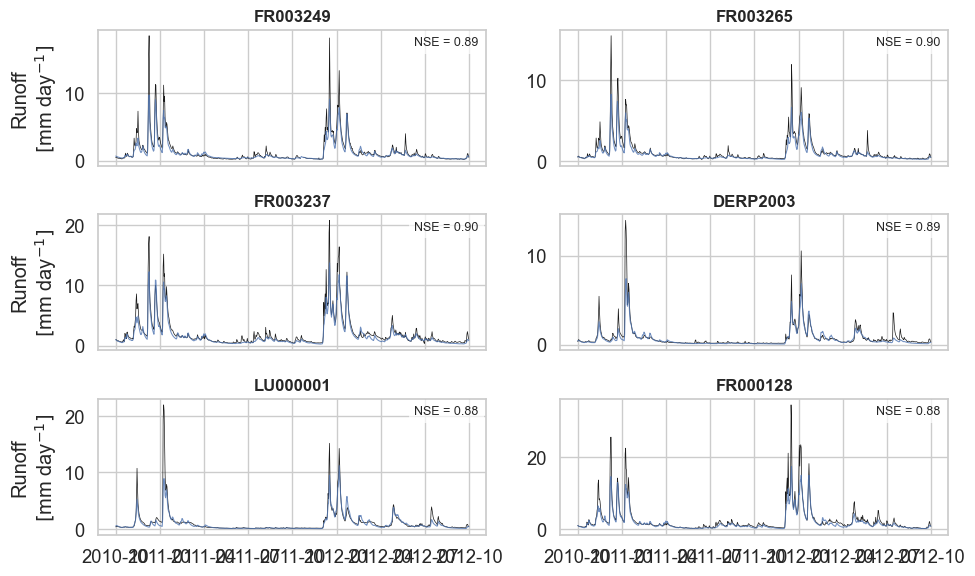

In [386]:
import matplotlib.pyplot as plt

# Define parameters
gauge_ids = ["FR003249", "FR003265", "FR003237", "DERP2003", "LU000001", "FR000128"]  # Your 6 gauge IDs
start_date = "2010-10-01"
end_date = "2012-09-30"

# Create subplots (2 columns × 3 rows)
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()  # Flatten to easily loop

# Plot each hydrograph
for i, gauge_id in enumerate(gauge_ids):
    ax = axes[i]
    
    # Subset the dataset for this gauge and time range
    ts = ds_mean.sel(gauge_id=gauge_id).sel(date=slice(start_date, end_date))
    
    # Plot observation and regional simulation
    ax.plot(ts.date, ts["observation"], label="Observation", linewidth=0.5, color="k")
    ax.plot(ts.date, ts["regional"], label="Regional", linewidth=0.75, alpha=0.8)
    
    ax.set_title(f"{gauge_id}", fontsize=12, fontweight="bold")
    #ax.set_ylim(0, 20)
    ax.grid(True)

    if i % 2 == 0:  # Left column
        ax.set_ylabel("Runoff\n$[$mm day$^{-1}]$")

    # Get NSE value (rounded for display)
    nse = data_diff_val_complete.loc[gauge_id, "nse_r1comp"]
    nse_label = f"NSE = {nse:.2f}"
    
    # Add NSE label inside the plot (top-right corner)
    ax.text(
        0.98, 0.95, nse_label,
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=9,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

    #if i == 5:
    #    ax.set_xticklabels(["1990", "1992", "1994", "1996", "1998", "2000"])



#axes[0].set_ylim(0, 10)
#axes[1].set_ylim(0, 10)


main_titles = [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", 
                r"$\mathbf{M_{\mathrm{reg}}}$"]

# Use last subplot for legend
#legend_ax = axes[-1]
#legend_ax.axis("off")

# Custom legend
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Observation", r"Mean simulation"]

legend_ax.legend(
    handles, labels,
    loc="center",
    frameon=False,
    ncol=3
)


fig.align_ylabels(axes)

plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for legend


# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/hydrographs_goodNSE_1year.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

## Study area

In [388]:
catchment_boundaries_moselle = catchment_boundaries.loc[network_estreams_gdf.index.tolist(), :]

In [389]:
world = gpd.read_file(r"/Users/nascimth/Documents/data/gis/world.shp")


/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_41271/31380701.py:34: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_geometry = moselle.unary_union
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_41271/31380701.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', fontsize=10)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_41271/31380701.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_41271/31380701.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=

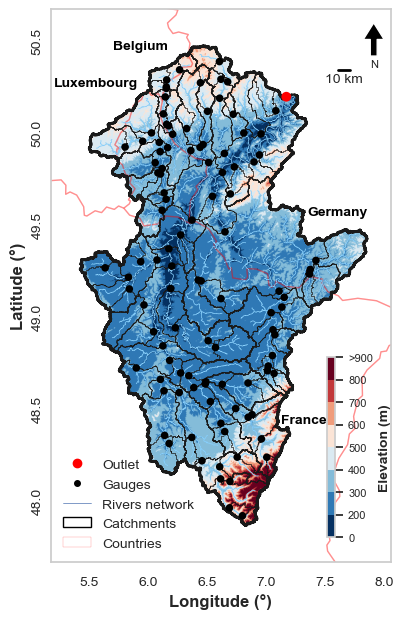

In [62]:
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm


# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, ax = plt.subplots(figsize=(4, 6))


data_df = estreams_attributes_dfs["DEBU1959"]
# Load the world shapefile dataset provided by GeoPandas

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 12           # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight


# Clear the subplot
ax.clear()

# Set the background color to white
ax.set_facecolor('white')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

world.plot(ax=ax, color='none', edgecolor='red', linewidth=1, alpha=0.25)

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Define the color classes (discrete intervals)
bounds = [0, 200, 300, 400, 500, 600, 700, 800, 900]  # Define class boundaries
cmap = plt.get_cmap('RdBu_r')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

# Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent)

# Add colorbar with class labels
#cbar = fig.colorbar(cax, ticks=bounds)
#cbar.set_label('Elevation (m)')
# Create a small colorbar inside the plot
cbar_ax = fig.add_axes([0.8, 0.12, 0.02, 0.3])  # [left, bottom, width, height]
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical', ticks=bounds)

tick_labels = [str(b) for b in bounds[:-1]] + ['>900']
cbar.ax.set_yticklabels(tick_labels)

cbar.ax.tick_params(labelsize=8)  # Set the font size for the ticks
cbar.set_label('Elevation (m)', fontsize=10)  # Set the label with a smaller font size

# Adjust the colorbar size (shrink)
#cbar.ax.set_aspect('auto')

# Set the title and show the plot
#ax.set_title('C', loc = "left", fontsize=14, fontweight="bold")

# Plot the river
rivers_moselle.plot(ax=ax, linewidth=0.5, color="lightskyblue")

# Plot the mask to cover everything outside the study area
#mask.plot(ax=ax, facecolor='none', edgecolor='darkred', linewidth=0.8)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Sub-catchments')

moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2, label='Sub-catchments')
catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.5, label='Sub-catchments')


# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax, color='black', markersize=30, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges', zorder=1000)

# Plot the points from network_estreams_filtered
network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax, color='red', markersize=50, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min-0.25, x_max+0.2)
ax.set_ylim(y_min-0.2, y_max+0.2)


ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=12)

# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', label='Catchments')
countries_patch = Patch(facecolor='none', edgecolor='red', lw=0.25, alpha = 0.5, label='Countries')

# For streamflow gauges (as black dots)
streamflow_marker = Line2D([0], [0], color='black', lw=0, marker='o', markersize=4, label='Gauges')

# For outlet gauges (as black dots)
outlet_marker = Line2D([0], [0], color='red', lw=0, marker='o', markersize=6, label='Outlet')

# For another line (representing rivers)
river_line = Line2D([0], [0], lw=0.5, label='Rivers network')

# Add the legend with all items
legend = ax.legend(handles=[outlet_marker, streamflow_marker, river_line, subcatchment_patch, countries_patch], 
                   loc='lower left', fontsize=10, title="", title_fontsize='8', frameon=False)

# Add a north arrow
x, y, arrow_length = 0.95, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=5, headwidth=15), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar 
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=10)

# Rotate the existing y-tick labels without changing them
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)

# Adding some text
ax.text(5.7, 50.4, 'Belgium', fontsize=10, color='black', fontweight='bold')
ax.text(5.2, 50.2, 'Luxembourg', fontsize=10, color='black', fontweight='bold')
ax.text(7.35, 49.50, 'Germany', fontsize=10, color='black', fontweight='bold')
ax.text(7.12, 48.37, 'France', fontsize=10, color='black', fontweight='bold')

import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#ax.set_aspect('equal')
ax.grid(False)
# Adjust the layout to remove extra space
plt.tight_layout(pad=0)

# Save including everything (colorbar + legend)
plt.savefig(
    r"C:\Users\nascimth\OneDrive - Eawag\Eawag\Papers\Moselle_superflexpy\GitHub\estreams_superflexpy\results\figs\study_area.png",
    dpi=300,
    bbox_inches='tight'
)
# Show the plot
plt.show()

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2522230756.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_geometry = moselle.unary_union
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2522230756.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', fontsize=10)
/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/2522230756.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)


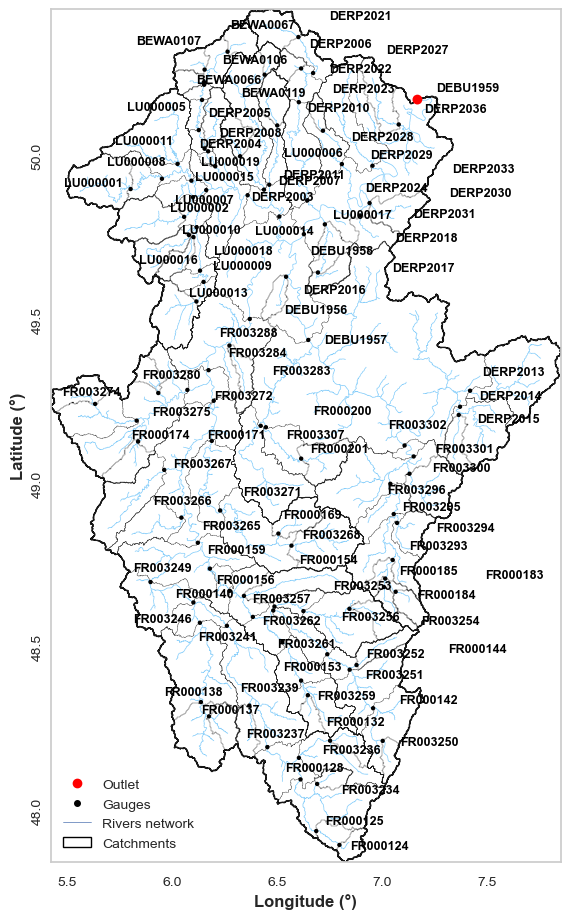

In [393]:
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
import adjustText
from adjustText import adjust_text

# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, ax = plt.subplots(figsize=(9, 9))


data_df = estreams_attributes_dfs["DEBU1959"]
# Load the world shapefile dataset provided by GeoPandas

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 12           # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight


# Clear the subplot
ax.clear()

# Set the background color to white
ax.set_facecolor('white')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)


# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Plot the river
rivers_moselle.plot(ax=ax, linewidth=0.5, color="lightskyblue")

# Plot the mask to cover everything outside the study area
#mask.plot(ax=ax, facecolor='none', edgecolor='darkred', linewidth=0.8)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Sub-catchments')

moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.5, label='Sub-catchments')
catchment_boundaries_moselle.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.25, label='Sub-catchments')


# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges', zorder=1000)

# Plot the points from network_estreams_filtered
network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax, color='red', markersize=50, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=12)

# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', label='Catchments')
countries_patch = Patch(facecolor='none', edgecolor='red', lw=0.25, alpha = 0.5, label='Countries')

# For streamflow gauges (as black dots)
streamflow_marker = Line2D([0], [0], color='black', lw=0, marker='o', markersize=4, label='Gauges')

# For outlet gauges (as black dots)
outlet_marker = Line2D([0], [0], color='red', lw=0, marker='o', markersize=6, label='Outlet')

# For another line (representing rivers)
river_line = Line2D([0], [0], lw=0.5, label='Rivers network')

# Add the legend with all items
legend = ax.legend(handles=[outlet_marker, streamflow_marker, river_line, subcatchment_patch], 
                   loc='lower left', fontsize=10, title="", title_fontsize='8', frameon=False)

# Rotate the existing y-tick labels without changing them
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)


# Add labels for selected basin_ids
label_df = network_estreams_gdf.index.tolist()


texts = []
for basin in label_df:
    x = network_estreams_gdf.loc[basin, 'lon']
    y = network_estreams_gdf.loc[basin, 'lat']
    texts.append(ax.text(x, y, basin, fontsize=9, ha='left', va='bottom', color='black', zorder=20, fontweight="bold"))

adjust_text(texts, ax=ax, expand_text=(0.5, 0.5))
    

import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#ax.set_aspect('equal')
ax.grid(False)
# Adjust the layout to remove extra space
plt.tight_layout(pad=0)

# Save including everything (colorbar + legend)
plt.savefig(
    "../results/figs/study_area2.png",
    dpi=300,
    bbox_inches='tight'
)
# Show the plot
plt.show()

In [ ]:
data_diff_cal_complete[["nse_r1comp"]].iloc[0:, :]



nse_r1comp
basin               
BEWA0066    0.884721
BEWA0067    0.829226
BEWA0106    0.816315
BEWA0107    0.740127
BEWA0119    0.855657
...              ...
LU000015    0.840160
LU000016    0.729672
LU000017    0.892114
LU000018    0.719885
LU000019    0.855812

[108 rows x 1 columns]

In [430]:
nse_dataframes_bestsmax = pd.read_csv("nse_dataframe_nse110.0.csv")
nse_dataframes_bestsmax.set_index("basin", inplace = True)

In [433]:
nse_dataframes_bestsmax

best_smax  best_nse  bedrk_dep  root_dep_mean
basin                                                  
BEWA0066      120.0  0.885128      1.112         77.402
BEWA0067       90.0  0.843680      1.054         81.200
BEWA0106      130.0  0.814733      1.113         68.182
BEWA0107      190.0  0.756057      1.210         68.052
BEWA0119      120.0  0.855392      1.110         76.692
...             ...       ...        ...            ...
LU000015      130.0  0.840653      1.106         67.233
LU000016      120.0  0.731966      1.264        109.436
LU000017      120.0  0.894402      1.166         92.007
LU000018      100.0  0.732184      1.132        129.277
LU000019      120.0  0.856863      1.123         72.895

[108 rows x 4 columns]

In [434]:
nse_dataframes_bestsmax["nse_r1comp"] = data_diff_cal_complete[["nse_r1comp"]]

In [437]:
nse_dataframes_bestsmax["diff"]= nse_dataframes_bestsmax["nse_r1comp"] - nse_dataframes_bestsmax["best_nse"]

In [444]:
nse_dataframes_bestsmax[nse_dataframes_bestsmax["diff"]<-0.05]

best_smax  best_nse  bedrk_dep  root_dep_mean  nse_r1comp      diff
basin                                                                        
DERP2013      180.0  0.425526      1.017        116.881    0.351403 -0.074123
FR000185      310.0  0.383646      0.912         92.353    0.287010 -0.096636
FR003250      350.0  0.218471      0.802         89.701    0.160563 -0.057909
FR003254       60.0  0.677846      1.020        108.435    0.610187 -0.067658
FR003259      350.0  0.403841      1.009        128.125    0.295944 -0.107897
FR003266      230.0  0.743365      1.178         97.080    0.659512 -0.083853

In [432]:
comparison_smaxbest = data_diff_cal_complete[["nse_r1comp"]].copy()
comparison_smaxbest

nse_r1comp
basin               
BEWA0066    0.884721
BEWA0067    0.829226
BEWA0106    0.816315
BEWA0107    0.740127
BEWA0119    0.855657
...              ...
LU000015    0.840160
LU000016    0.729672
LU000017    0.892114
LU000018    0.719885
LU000019    0.855812

[108 rows x 1 columns]

In [ ]:
comparison_smaxbest[]

In [441]:
data_diff_cal_complete.loc["FR003254", "nse_r1comp"]

0.610187485489967

In [ ]:
LU000001,0.8657749052493962
LU000002,0.8543916049906858
LU000005,0.8684187682291542
LU000006,0.8909391236170556
LU000007,0.8363421798050445
LU000008,0.6796684309946375
LU000009,0.7601844547894491
LU000010,0.8154526810847887
LU000011,0.8511751956801284
LU000013,0.5966456811440609
LU000014,0.7834883631366232
LU000015,0.8344572830376372
LU000016,0.7309927465319036
LU000017,0.8942916071114692
LU000018,0.7309218219745194
LU000019,0.8564042823259209

## Correlations

In [ ]:
estreams_attributes_clipped_filters["nse_r1comp"] = data_diff_val_complete["nse_r1comp"]
estreams_attributes_clipped_filters["nse_c1comp"] = data_diff_val_complete["nse_c1comp"]
estreams_attributes_clipped_filters["nse_g1comp"] = data_diff_val_complete["nse_g1comp"]
estreams_attributes_clipped_filters["nse_nogeo"] = data_diff_val_complete["nse_nogeo"]
estreams_attributes_clipped_filters["bfi_obs"] = data_diff_val_complete["bfi_obs"]

estreams_attributes_clipped_filters_plot = estreams_attributes_clipped_filters.copy()
estreams_attributes_clipped_filters_plot.drop("group", inplace=True, axis=1)
estreams_attributes_clipped_filters_plot_nodup = estreams_attributes_clipped_filters_plot[~estreams_attributes_clipped_filters_plot.index.duplicated(keep='first')]

corr_series = estreams_attributes_clipped_filters_plot.iloc[:, 30:].corr(method="pearson")["nse_r1comp"]
filtered_corr = corr_series[abs(corr_series) > 0.0]

filtered_corr[20:40]

hp_time              0.177592
lp_freq             -0.134643
lp_dur              -0.055368
lp_time              0.003003
ele_mt_max           0.086191
ele_mt_mean         -0.055292
ele_mt_min          -0.209492
slp_dg_mean         -0.327373
flat_area_fra        0.105842
steep_area_fra      -0.391878
elon_ratio           0.107290
strm_dens            0.095330
lit_dom             -0.104059
bedrk_dep            0.246346
perm_verylow_glob   -0.058676
perm_low_glob        0.225860
perm_medium_glob     0.116904
perm_high_glob      -0.162575
lit_fra_su           0.213669
lit_fra_ss          -0.188595
Name: nse_r1comp, dtype: float64

In [255]:
corr_series = estreams_attributes_clipped_filters_plot.iloc[:, 30:].corr(method="pearson")["nse_g1comp"]
filtered_corr = corr_series[abs(corr_series) > 0.2]

filtered_corr

baseflow_index          -0.350780
hfd_mean                -0.562909
hfd_std                 -0.387888
q_5                     -0.301418
ele_mt_min              -0.252699
slp_dg_mean             -0.348164
flat_area_fra            0.215324
steep_area_fra          -0.365503
lit_dom                 -0.260917
bedrk_dep                0.288581
perm_low_glob            0.243043
perm_medium_glob         0.316502
perm_high_glob          -0.438156
lit_fra_su               0.245900
lit_fra_ss              -0.468065
lit_fra_sc               0.222571
lit_fra_mt               0.243043
lit_fra_va              -0.605153
perm_high_cont          -0.347528
lit_fra_Gravels          0.259607
lit_fra_Sandstones      -0.400697
root_dep_mean            0.326305
root_dep_max             0.235405
soil_tawc_mean           0.231448
soil_fra_sand_mean      -0.335098
soil_fra_silt_mean       0.256047
soil_fra_clay_mean       0.301505
soil_fra_grav_mean       0.370237
soil_bd_mean            -0.372585
lai_mean      

In [254]:
data_diff_val_complete.min() 

nse_nogeo        -0.454676
nse_g1comp        0.136366
nse_c1comp        0.107801
nse_r1comp        0.231655
bfi_obs           0.420919
bfi_r1comp        0.502541
bfi_c1comp        0.525490
bfi_g1comp        0.512278
bfi_nogeo         0.596098
hfd_obs          97.277778
hfd_r1comp      124.240000
hfd_c1comp      126.240000
hfd_g1comp      124.720000
hfd_nogeo       131.360000
slope_obs         0.958338
slope_r1comp      1.202587
slope_c1comp      1.152111
slope_g1comp      1.340480
slope_nogeo       1.840529
qmean_obs         0.518305
qmean_r1comp      0.600298
qmean_c1comp      0.604913
qmean_g1comp      0.610238
qmean_nogeo       0.598977
dtype: float64

/var/folders/sd/ytjf58757690_xfckxng56q00000gq/T/ipykernel_12599/1986564004.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  estreams_attributes_clipped_filters_plot_nodup["marker_size"] = estreams_attributes_clipped_filters_plot_nodup["area_estreams"].apply(get_marker_size)


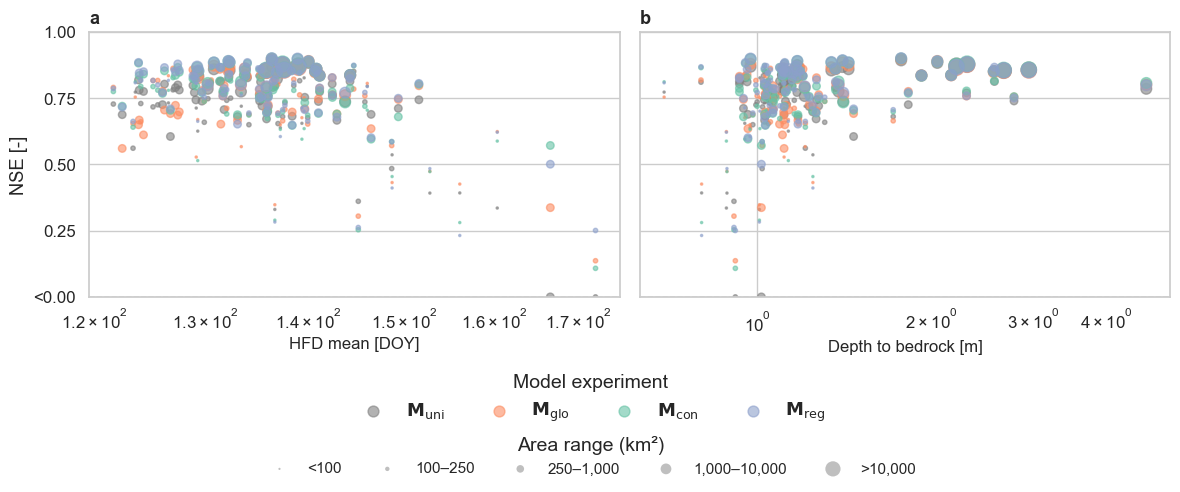

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.1)

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Define the two variables to plot
panels = [
    ("hfd_mean", "HFD mean [DOY]", "a"),
    ("bedrk_dep", "Depth to bedrock [m]", "b"),
]

# Define NSE columns and colors
nse_columns = {
    "nse_nogeo": "gray",
    "nse_g1comp": "#fc8d62",
    "nse_c1comp": "#66c2a5",
    "nse_r1comp": "#8da0cb",
}

# Function to determine marker size
def get_marker_size(area):
    if area < 100:
        return 2.5
    elif 100 <= area < 250:
        return 10
    elif 250 <= area < 1000:
        return 30
    elif 1000 <= area < 10000:
        return 60
    else:
        return 120

# Pre-compute marker sizes based on catchment area
estreams_attributes_clipped_filters_plot_nodup["marker_size"] = estreams_attributes_clipped_filters_plot_nodup["area_estreams"].apply(get_marker_size)

# Loop through the panels
for i, (x_col, xlabel, label) in enumerate(panels):
    ax = axes[i]

    for nse_col, color in nse_columns.items():
        x = estreams_attributes_clipped_filters_plot_nodup[x_col]
        y = estreams_attributes_clipped_filters_plot_nodup[nse_col].clip(lower=0, upper=1)
        sizes = estreams_attributes_clipped_filters_plot_nodup["marker_size"]

        ax.scatter(x, y, color=color, label=nse_col if i == 0 else "", alpha=0.6, s=sizes)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("NSE [-]" if i == 0 else "")
    ax.set_title(label, loc='left', fontsize=13, fontweight="bold")
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["<0.00", "0.25", "0.50", "0.75", "1.00"])
    ax.set_ylim(0, 1)

# First legend: NSE model experiment
handles_model, _ = axes[0].get_legend_handles_labels()
fig.legend(
    handles_model,
    [r"$\mathbf{M_{\mathrm{uni}}}$", r"$\mathbf{M_{\mathrm{glo}}}$", r"$\mathbf{M_{\mathrm{con}}}$", r"$\mathbf{M_{\mathrm{reg}}}$"],
    title="Model experiment",
    loc='lower center',
    ncol=4,
    fontsize=13,
    title_fontsize=14,
    frameon=False,
    bbox_to_anchor=(0.5, 0.1)  # slightly below plot
)

# Second legend: Marker size (area)
size_handles = [
    plt.scatter([], [], s=2.5,  color="gray", alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=10,   color="gray",alpha=0.5, label='100–250', edgecolors='none'),
    plt.scatter([], [], s=30,   color="gray",alpha=0.5, label='250–1,000', edgecolors='none'),
    plt.scatter([], [], s=60,   color="gray",alpha=0.5, label='1,000–10,000', edgecolors='none'),
    plt.scatter([], [], s=120,  color="gray",alpha=0.5, label='>10,000', edgecolors='none')
]

fig.legend(
    handles=size_handles,
    title='Area range (km²)',
    loc='lower center',
    ncol=5,
    bbox_to_anchor=(0.5, 0),  # lower than the model legend
    frameon=False,
    fontsize=11,
    title_fontsize=14
)
axes[0].set_xscale("log")
axes[1].set_xscale("log")
# Adjust layout to reserve enough space for both legends
plt.tight_layout(rect=[0, 0.23, 1, 1])  # leave more space at the bottom

# Save figure
plt.savefig(
    "../results/figs/correlations_hfd_bedrockarea_scaled.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


# Visualization of the params

In [292]:
import re

def is_valid_key(k):
    # Exclude keys that end in Group_X_2
    return not re.search(r'Group_\d+_2$', k)

def is_valid_key_2(k):
    # Include only keys that end in Group_X_2
    return re.search(r'Group_\d+_2$', k)

In [293]:
import os
import glob

# Dictionary to store all parameter dicts
all_param_dicts = {}

# Loop through all CSVs in the current directory
for filepath in glob.glob("../results/groups/*moselle*comp*.csv"):
    file_key = os.path.splitext(os.path.basename(filepath))[0]  # Strip .csv
    
    param_dict = {}

    # Read file and parse lines
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(","):  # Skip empty or malformed lines
                continue
            parts = line.split(",")
            if len(parts) == 2:
                key, value = parts
                try:
                    param_dict[key] = float(value)
                except ValueError:
                    pass  # Skip lines where value is not a float
            else:
                pass  # Skip malformed lines

    # Store the parsed dictionary
    all_param_dicts[file_key] = param_dict


In [294]:
regional_keys_2 = [k for k in all_param_dicts if "regi" in k and is_valid_key_2(k)]
continental_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]


In [295]:
regional_keys_1 = [k for k in all_param_dicts if "regi" in k and is_valid_key(k)]
continental_keys_1 = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
global_keys_1 = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

In [296]:
dfs=[]
for key in regional_keys_2:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

regional_params_2 = pd.concat(dfs)
regional_params_2.high_snow_k = 1/regional_params_2.high_snow_k
regional_params_2.high_slow_k = 1/regional_params_2.high_slow_k
regional_params_2.high_fast_k = 1/regional_params_2.high_fast_k
regional_params_2.general_snow_k = 1/regional_params_2.general_snow_k
regional_params_2.general_slow_k = 1/regional_params_2.general_slow_k
regional_params_2.general_fast_k = 1/regional_params_2.general_fast_k
regional_params_2.low_snow_k = 1/regional_params_2.low_snow_k
regional_params_2.low_slow_k = 1/regional_params_2.low_slow_k
regional_params_2.low_fast_k = 1/regional_params_2.low_fast_k

dfs=[]
for key in regional_keys_1:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

regional_params_1 = pd.concat(dfs)
regional_params_1.high_snow_k = 1/regional_params_1.high_snow_k
regional_params_1.high_slow_k = 1/regional_params_1.high_slow_k
regional_params_1.high_fast_k = 1/regional_params_1.high_fast_k
regional_params_1.general_snow_k = 1/regional_params_1.general_snow_k
regional_params_1.general_slow_k = 1/regional_params_1.general_slow_k
regional_params_1.general_fast_k = 1/regional_params_1.general_fast_k
regional_params_1.low_snow_k = 1/regional_params_1.low_snow_k
regional_params_1.low_slow_k = 1/regional_params_1.low_slow_k
regional_params_1.low_fast_k = 1/regional_params_1.low_fast_k

regional_params_1

high_snow_k  high_unsaturated_Smax  high_unsaturated_Ce  \
0     0.346792             127.321406             0.749946   
0     0.364328             121.526910             0.762403   
0     0.339948             123.550093             0.764848   
0     0.385650             143.310800             0.779519   
0     0.315002             126.428235             0.700266   
0     0.358641             130.728600             0.791150   
0     0.328474             124.055970             0.749512   

   high_unsaturated_beta  high_lowersplitter_splitpar  high_slow_k  \
0               2.249435                     0.449088   410.594629   
0               2.401420                     0.693623   490.773251   
0               2.316849                     0.616640   481.216858   
0               2.386952                     0.824092   444.903704   
0               3.061847                     0.884068   273.217283   
0               2.060613                     0.529052   882.543441   
0               1.954776                     0.517091   516.443696   

   high_lag-fun_lag-time  high_fast_k  general_snow_k  \
0               1.995418   531.315958        0.346792   
0               1.998690    96.975647        0.364328   
0               2.035121   331.087394        0.339948   
0               2.128160     2.039247        0.385650   
0               1.993162     2.700500        0.315002   
0               2.130810   616.049228        0.358641   
0               2.040960   399.849049        0.328474   

   general_unsaturated_Smax  ...  general_lag-fun_lag-time  general_fast_k  \
0                127.321406  ...                  1.995418       37.418038   
0                121.526910  ...                  1.998690       23.795617   
0                123.550093  ...                  2.035121       29.899827   
0                143.310800  ...                  2.128160       44.397515   
0                126.428235  ...                  1.993162       52.312235   
0                130.728600  ...                  2.130810       32.846986   
0                124.055970  ...                  2.040960       70.876856   

   low_snow_k  low_unsaturated_Smax  low_unsaturated_Ce  low_unsaturated_beta  \
0    0.346792            127.321406            0.749946              2.249435   
0    0.364328            121.526910            0.762403              2.401420   
0    0.339948            123.550093            0.764848              2.316849   
0    0.385650            143.310800            0.779519              2.386952   
0    0.315002            126.428235            0.700266              3.061847   
0    0.358641            130.728600            0.791150              2.060613   
0    0.328474            124.055970            0.749512              1.954776   

   low_lowersplitter_splitpar  low_slow_k  low_lag-fun_lag-time  low_fast_k  
0                    0.298026   16.883437              1.995418   82.512722  
0                    0.266680   16.961404              1.998690   84.677320  
0                    0.331856   11.912578              2.035121   32.202776  
0                    0.654370   10.972795              2.128160   14.866188  
0                    0.726554   10.234316              1.993162    6.352938  
0                    0.484139   10.450055              2.130810   29.301874  
0                    0.459895   49.303067              2.040960   54.248613  

[7 rows x 24 columns]

In [297]:
dfs=[]
for key in continental_keys_2:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

continental_params_2 = pd.concat(dfs)
continental_params_2.high_snow_k = 1/continental_params_2.high_snow_k
continental_params_2.high_slow_k = 1/continental_params_2.high_slow_k
continental_params_2.high_fast_k = 1/continental_params_2.high_fast_k
continental_params_2.general_snow_k = 1/continental_params_2.general_snow_k
continental_params_2.general_slow_k = 1/continental_params_2.general_slow_k
continental_params_2.general_fast_k = 1/continental_params_2.general_fast_k
continental_params_2.low_snow_k = 1/continental_params_2.low_snow_k
continental_params_2.low_slow_k = 1/continental_params_2.low_slow_k
continental_params_2.low_fast_k = 1/continental_params_2.low_fast_k

dfs=[]
for key in continental_keys_1:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

continental_params_1 = pd.concat(dfs)
continental_params_1.high_snow_k = 1/continental_params_1.high_snow_k
continental_params_1.high_slow_k = 1/continental_params_1.high_slow_k
continental_params_1.high_fast_k = 1/continental_params_1.high_fast_k
continental_params_1.general_snow_k = 1/continental_params_1.general_snow_k
continental_params_1.general_slow_k = 1/continental_params_1.general_slow_k
continental_params_1.general_fast_k = 1/continental_params_1.general_fast_k
continental_params_1.low_snow_k = 1/continental_params_1.low_snow_k
continental_params_1.low_slow_k = 1/continental_params_1.low_slow_k
continental_params_1.low_fast_k = 1/continental_params_1.low_fast_k

continental_params_2

high_snow_k  high_unsaturated_Smax  high_unsaturated_Ce  \
0     0.428738             145.406964             0.931931   
0     0.300590             162.305497             1.168430   
0     0.414207             159.777711             0.899771   
0     0.594094             160.003838             1.021613   
0     0.406181             142.337130             0.989215   
0     0.470732             149.490816             1.260205   
0     0.532997             147.281818             0.969870   

   high_unsaturated_beta  high_lowersplitter_splitpar  high_slow_k  \
0               1.440335                     0.641605  1298.440567   
0               1.212444                     0.556103   287.881307   
0               1.490362                     0.895903   375.482528   
0               1.151007                     0.457242   356.886699   
0               1.309709                     0.487312   341.120805   
0               0.959812                     0.788995   310.013247   
0               1.206350                     0.756880   355.876054   

   high_lag-fun_lag-time  high_fast_k  general_snow_k  \
0               1.997099   162.066266        0.428738   
0               2.040640   227.189204        0.300590   
0               2.051974    14.735857        0.414207   
0               2.124266   323.837620        0.594094   
0               1.993460   534.426657        0.406181   
0               2.087202     4.575136        0.470732   
0               2.095688     3.325895        0.532997   

   general_unsaturated_Smax  ...  general_lag-fun_lag-time  general_fast_k  \
0                145.406964  ...                  1.997099       51.423690   
0                162.305497  ...                  2.040640       62.748478   
0                159.777711  ...                  2.051974       57.326472   
0                160.003838  ...                  2.124266       50.798495   
0                142.337130  ...                  1.993460       47.522709   
0                149.490816  ...                  2.087202       69.158574   
0                147.281818  ...                  2.095688      141.464207   

   low_snow_k  low_unsaturated_Smax  low_unsaturated_Ce  low_unsaturated_beta  \
0    0.428738            145.406964            0.931931              1.440335   
0    0.300590            162.305497            1.168430              1.212444   
0    0.414207            159.777711            0.899771              1.490362   
0    0.594094            160.003838            1.021613              1.151007   
0    0.406181            142.337130            0.989215              1.309709   
0    0.470732            149.490816            1.260205              0.959812   
0    0.532997            147.281818            0.969870              1.206350   

   low_lowersplitter_splitpar  low_slow_k  low_lag-fun_lag-time  low_fast_k  
0                    0.244777   15.843361              1.997099   96.643820  
0                    0.107879   52.207332              2.040640   86.655056  
0                    0.725397   10.773033              2.051974   24.063178  
0                    0.545561   19.509296              2.124266   30.212840  
0                    0.331068   40.654198              1.993460   63.871081  
0                    0.221848   57.353677              2.087202  137.284059  
0                    0.387947  111.612026              2.095688  134.604082  

[7 rows x 24 columns]

In [298]:
dfs=[]
for key in global_keys_2:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

global_params_2 = pd.concat(dfs)
global_params_2.high_snow_k = 1/global_params_2.high_snow_k
global_params_2.high_slow_k = 1/global_params_2.high_slow_k
global_params_2.high_fast_k = 1/global_params_2.high_fast_k
global_params_2.general_snow_k = 1/global_params_2.general_snow_k
global_params_2.general_slow_k = 1/global_params_2.general_slow_k
global_params_2.general_fast_k = 1/global_params_2.general_fast_k
global_params_2.low_snow_k = 1/global_params_2.low_snow_k
global_params_2.low_slow_k = 1/global_params_2.low_slow_k
global_params_2.low_fast_k = 1/global_params_2.low_fast_k

dfs=[]
for key in global_keys_1:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

global_params_1 = pd.concat(dfs)
global_params_1.high_snow_k = 1/global_params_1.high_snow_k
global_params_1.high_slow_k = 1/global_params_1.high_slow_k
global_params_1.high_fast_k = 1/global_params_1.high_fast_k
global_params_1.general_snow_k = 1/global_params_1.general_snow_k
global_params_1.general_slow_k = 1/global_params_1.general_slow_k
global_params_1.general_fast_k = 1/global_params_1.general_fast_k
global_params_1.low_snow_k = 1/global_params_1.low_snow_k
global_params_1.low_slow_k = 1/global_params_1.low_slow_k
global_params_1.low_fast_k = 1/global_params_1.low_fast_k

global_params_1

high_snow_k  high_unsaturated_Smax  high_unsaturated_Ce  \
0     0.338556             129.599104             0.731704   
0     0.281726             140.471416             0.872088   
0     0.256286             126.458050             0.694831   
0     0.207184             130.718830             0.859041   
0     0.417049             118.598117             0.755744   
0     0.375215             148.358870             0.650398   
0     0.263775             121.792695             0.764024   

   high_unsaturated_beta  high_lowersplitter_splitpar  high_slow_k  \
0               3.291096                     0.793925   269.950748   
0               1.501382                     0.631044   529.015980   
0               2.552835                     0.550318   275.147422   
0               1.570424                     0.564327   288.340806   
0               2.980238                     0.669594   562.385374   
0               4.649047                     0.325405   626.385800   
0               2.422288                     0.534666   728.251501   

   high_lag-fun_lag-time  high_fast_k  general_snow_k  \
0               1.981996    13.101528        0.338556   
0               1.913164    51.771687        0.281726   
0               2.010927   431.905149        0.256286   
0               2.041436   184.873504        0.207184   
0               2.001336    76.201946        0.417049   
0               2.008956   381.300272        0.375215   
0               1.993199   262.130093        0.263775   

   general_unsaturated_Smax  ...  general_lag-fun_lag-time  general_fast_k  \
0                129.599104  ...                  1.981996       51.708281   
0                140.471416  ...                  1.913164       53.413703   
0                126.458050  ...                  2.010927       65.498092   
0                130.718830  ...                  2.041436       40.699113   
0                118.598117  ...                  2.001336       31.913085   
0                148.358870  ...                  2.008956       37.162690   
0                121.792695  ...                  1.993199       39.619618   

   low_snow_k  low_unsaturated_Smax  low_unsaturated_Ce  low_unsaturated_beta  \
0    0.338556            129.599104            0.731704              3.291096   
0    0.281726            140.471416            0.872088              1.501382   
0    0.256286            126.458050            0.694831              2.552835   
0    0.207184            130.718830            0.859041              1.570424   
0    0.417049            118.598117            0.755744              2.980238   
0    0.375215            148.358870            0.650398              4.649047   
0    0.263775            121.792695            0.764024              2.422288   

   low_lowersplitter_splitpar  low_slow_k  low_lag-fun_lag-time  low_fast_k  
0                    0.605961   10.511354              1.981996  148.963517  
0                    0.851252   10.333201              1.913164    3.780372  
0                    0.840695   45.390095              2.010927    2.267059  
0                    0.874414   44.232752              2.041436    1.009084  
0                    0.226697   18.446088              2.001336  377.646543  
0                    0.746139   12.202076              2.008956    1.009829  
0                    0.875842  120.149684              1.993199    1.683478  

[7 rows x 24 columns]

In [299]:
import warnings
warnings.filterwarnings("ignore")

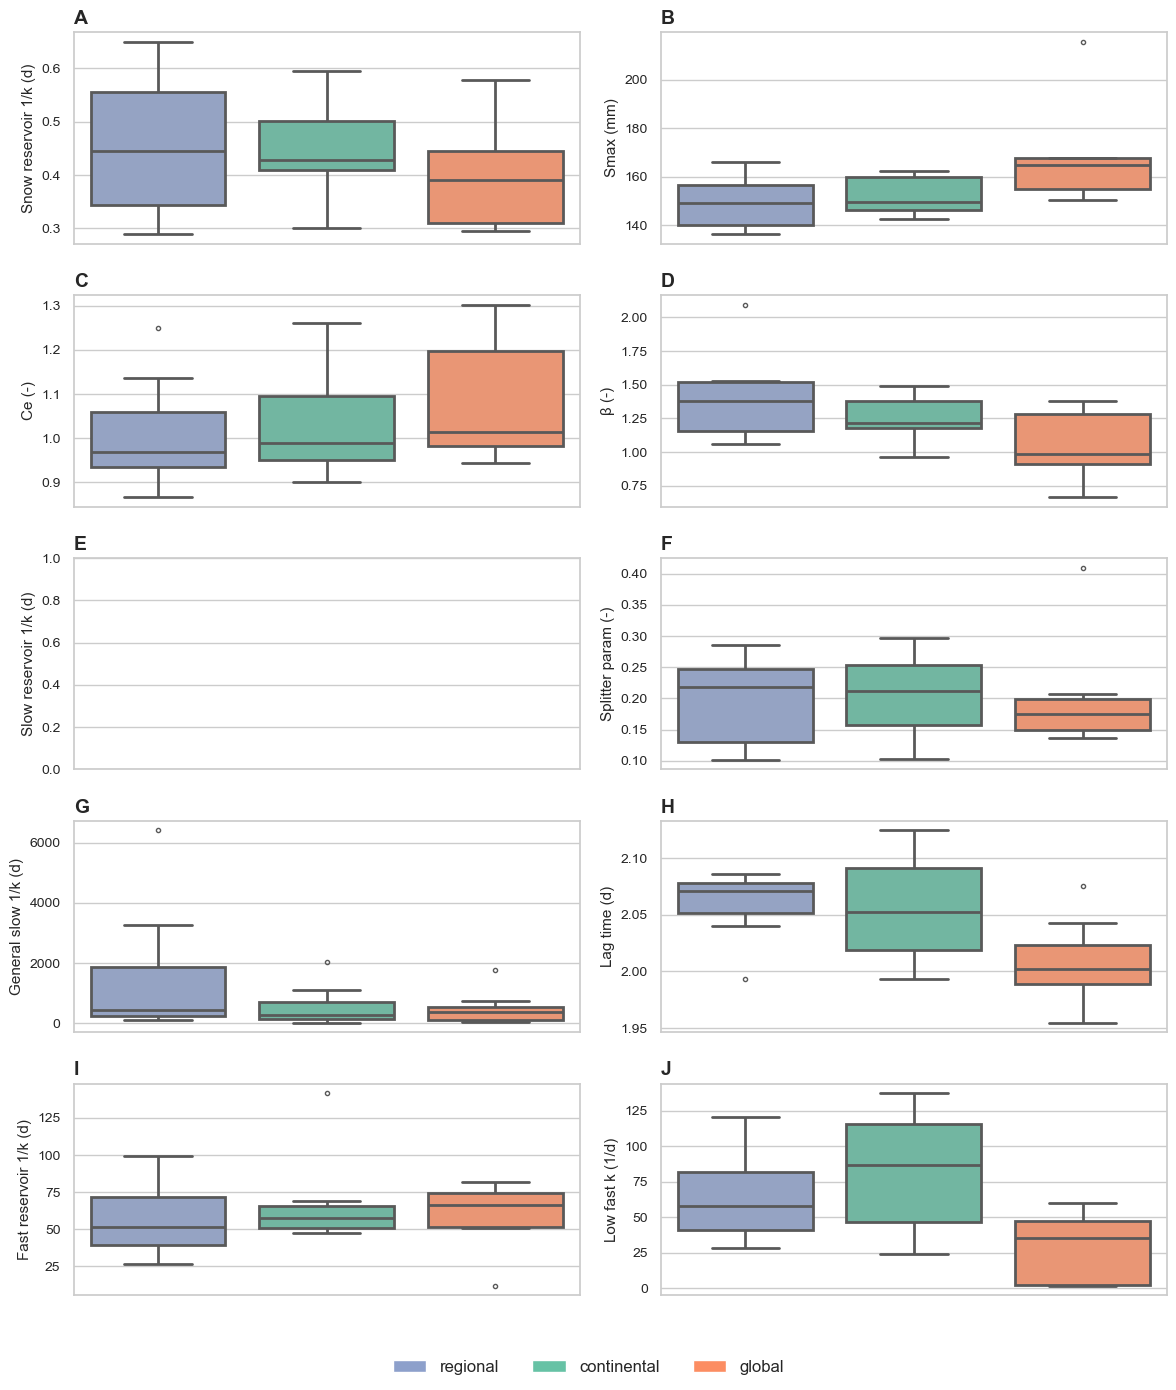

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

subplot_titles = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")  # Enough for 26 variables


# Seaborn styling
sns.set_theme(style="whitegrid", font_scale=1.2)

# Prepare long-format data
def prepare_long_df(df, name):
    df_long = df.copy()
    df_long['source'] = name
    return df_long

regional_long = prepare_long_df(regional_params_2, 'regional')
continental_long = prepare_long_df(continental_params_2, 'continental')
global_long = prepare_long_df(global_params_2, 'global')

all_long = pd.concat([regional_long, continental_long, global_long], axis=0)
all_long = all_long.melt(id_vars='source', var_name='variable', value_name='value')

# Colors for groups
palette = {
    'regional': '#8da0cb',     # blue
    'continental': '#66c2a5',  # green
    'global': '#fc8d62'        # orange
}

# Variables to plot
variables = [
    'high_snow_k', 
    'high_unsaturated_Smax', 
    'high_unsaturated_Ce',
    'high_unsaturated_beta', 
    'high_slowhigh_k', 
    'general_lowersplitter_splitpar',
    'general_slow_k', 
    'general_lag-fun_lag-time', 
    'general_fast_k',
    'low_fast_k'
]


# Pretty labels for y-axes
pretty_labels = {
    'high_snow_k': 'Snow reservoir 1/k (d)',#
    'high_unsaturated_Smax': 'Smax (mm)',#
    'high_unsaturated_Ce': 'Ce (-)',#
    'high_unsaturated_beta': 'β (-)',#
    'high_slowhigh_k': 'Slow reservoir 1/k (d)',#
    'general_lowersplitter_splitpar': 'Splitter param (-)',#
    'general_slow_k': 'General slow 1/k (d)',#
    'general_lag-fun_lag-time': 'Lag time (d)',#
    'general_fast_k': 'Fast reservoir 1/k (d)',#
    'low_fast_k': 'Low fast k (1/d)'#
}

# Layout
ncols = 2
nrows = int(np.ceil(len(variables) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14), sharey=False)
axes = axes.flatten()

# Plot
for i, var in enumerate(variables):
    ax = axes[i]
    sns.boxplot(
        data=all_long[all_long['variable'] == var],
        x='source', y='value',
        palette=palette,
        linewidth=2.0,
        fliersize=3,
        ax=ax
    )
    ax.set_title(subplot_titles[i], fontsize=14, weight='bold', loc="left")  # "A", "B", ...
    ax.set_xlabel('')
    ax.set_ylabel(pretty_labels.get(var, var), fontsize=11)
    ax.set_xticks([])  # remove x-axis group labels
    ax.tick_params(labelsize=10)

# Hide unused axes
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Custom legend
legend_elements = [
    Patch(facecolor=palette['regional'], label='regional'),
    Patch(facecolor=palette['continental'], label='continental'),
    Patch(facecolor=palette['global'], label='global')
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=3,
    fontsize=12,
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.savefig(r"C:\Users\nascimth\OneDrive - Eawag\Eawag\Papers\Moselle_superflexpy\GitHub\estreams_superflexpy\results\figs\boxplots_params.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()

In [76]:
regional_params_1.columns

Index(['high_snow_k', 'high_unsaturated_Smax', 'high_unsaturated_Ce',
       'high_unsaturated_beta', 'high_lowersplitter_splitpar', 'high_slow_k',
       'high_lag-fun_lag-time', 'high_fast_k', 'general_snow_k',
       'general_unsaturated_Smax', 'general_unsaturated_Ce',
       'general_unsaturated_beta', 'general_lowersplitter_splitpar',
       'general_slow_k', 'general_lag-fun_lag-time', 'general_fast_k',
       'low_snow_k', 'low_unsaturated_Smax', 'low_unsaturated_Ce',
       'low_unsaturated_beta', 'low_lowersplitter_splitpar', 'low_slow_k',
       'low_lag-fun_lag-time', 'low_fast_k'],
      dtype='object')

In [306]:
regional_params = pd.concat([regional_params_1, regional_params_2])
continental_params = pd.concat([continental_params_1, continental_params_2])
global_params = pd.concat([global_params_1, global_params_2])


In [318]:
global_params.describe()

high_snow_k  high_unsaturated_Smax  high_unsaturated_Ce  \
count    14.000000              14.000000            14.000000   
mean      0.351145             149.378877             0.924596   
std       0.097880              25.486629             0.204594   
min       0.207184             118.598117             0.650398   
25%       0.285270             129.879036             0.757814   
50%       0.329202             149.251043             0.907233   
75%       0.410635             163.251648             1.006708   
max       0.577784             215.622180             1.302126   

       high_unsaturated_beta  high_lowersplitter_splitpar  high_slow_k  \
count              14.000000                    14.000000    14.000000   
mean                1.884026                     0.557284   414.992405   
std                 1.143014                     0.123225   217.008939   
min                 0.666162                     0.325405    39.136182   
25%                 1.060126                     0.484990   278.445768   
50%                 1.439852                     0.569601   393.482408   
75%                 2.520198                     0.630167   569.788482   
max                 4.649047                     0.793925   728.251501   

       high_lag-fun_lag-time  high_fast_k  general_snow_k  \
count              14.000000    14.000000       14.000000   
mean                2.000551   216.626620        0.351145   
std                 0.038790   153.513579        0.097880   
min                 1.913164    13.101528        0.207184   
25%                 1.988692    62.296712        0.285270   
50%                 2.001863   219.659563        0.329202   
75%                 2.010434   297.306009        0.410635   
max                 2.075170   495.749588        0.577784   

       general_unsaturated_Smax  ...  general_lag-fun_lag-time  \
count                 14.000000  ...                 14.000000   
mean                 149.378877  ...                  2.000551   
std                   25.486629  ...                  0.038790   
min                  118.598117  ...                  1.913164   
25%                  129.879036  ...                  1.988692   
50%                  149.251043  ...                  2.001863   
75%                  163.251648  ...                  2.010434   
max                  215.622180  ...                  2.075170   

       general_fast_k  low_snow_k  low_unsaturated_Smax  low_unsaturated_Ce  \
count       14.000000   14.000000             14.000000           14.000000   
mean        52.371118    0.351145            149.378877            0.924596   
std         19.223034    0.097880             25.486629            0.204594   
min         12.151650    0.207184            118.598117            0.650398   
25%         39.889492    0.285270            129.879036            0.757814   
50%         52.177604    0.329202            149.251043            0.907233   
75%         66.148995    0.410635            163.251648            1.006708   
max         81.939656    0.577784            215.622180            1.302126   

       low_unsaturated_beta  low_lowersplitter_splitpar  low_slow_k  \
count             14.000000                   14.000000   14.000000   
mean               1.884026                    0.736015   31.395705   
std                1.143014                    0.171865   31.947321   
min                0.666162                    0.226697   10.333201   
25%                1.060126                    0.692057   12.211885   
50%                1.439852                    0.781419   14.425780   
75%                2.520198                    0.850002   43.182788   
max                4.649047                    0.875842  120.149684   

       low_lag-fun_lag-time  low_fast_k  
count             14.000000   14.000000  
mean               2.000551   52.331220  
std                0.038790  102.268077  
min                1.913164    1.009084  
25%                1.988692    2.04350

In [319]:
regional_params.describe()

high_snow_k  high_unsaturated_Smax  high_unsaturated_Ce  \
count    14.000000              14.000000            14.000000   
mean      0.401523             138.704359             0.883600   
std       0.110479              14.195639             0.161151   
min       0.289391             121.526910             0.700266   
25%       0.340345             126.651527             0.763014   
50%       0.352717             137.954830             0.828857   
75%       0.429677             147.662423             0.963559   
max       0.649169             166.053920             1.248892   

       high_unsaturated_beta  high_lowersplitter_splitpar  high_slow_k  \
count              14.000000                    14.000000    14.000000   
mean                1.880376                     0.639567   450.615798   
std                 0.592462                     0.137759   186.662020   
min                 1.062050                     0.449088   194.411978   
25%                 1.413189                     0.536639   308.787148   
50%                 2.007695                     0.596873   427.749167   
75%                 2.299996                     0.766783   510.026085   
max                 3.061847                     0.884068   882.543441   

       high_lag-fun_lag-time  high_fast_k  general_snow_k  \
count              14.000000    14.000000       14.000000   
mean                2.052270   242.469791        0.401523   
std                 0.046935   202.831881        0.110479   
min                 1.993162     1.689514        0.289391   
25%                 2.007798    26.446489        0.340345   
50%                 2.052290   248.787934        0.352717   
75%                 2.081602   382.658635        0.429677   
max                 2.130810   616.049228        0.649169   

       general_unsaturated_Smax  ...  general_lag-fun_lag-time  \
count                 14.000000  ...                 14.000000   
mean                 138.704359  ...                  2.052270   
std                   14.195639  ...                  0.046935   
min                  121.526910  ...                  1.993162   
25%                  126.651527  ...                  2.007798   
50%                  137.954830  ...                  2.052290   
75%                  147.662423  ...                  2.081602   
max                  166.053920  ...                  2.130810   

       general_fast_k  low_snow_k  low_unsaturated_Smax  low_unsaturated_Ce  \
count       14.000000   14.000000             14.000000           14.000000   
mean        49.461702    0.401523            138.704359            0.883600   
std         22.342807    0.110479             14.195639            0.161151   
min         23.795617    0.289391            121.526910            0.700266   
25%         33.989749    0.340345            126.651527            0.763014   
50%         42.790449    0.352717            137.954830            0.828857   
75%         57.466152    0.429677            147.662423            0.963559   
max         99.450783    0.649169            166.053920            1.248892   

       low_unsaturated_beta  low_lowersplitter_splitpar  low_slow_k  \
count             14.000000                   14.000000   14.000000   
mean               1.880376                    0.417141   19.191525   
std                0.592462                    0.167939   15.083866   
min                1.062050                    0.149388   10.234316   
25%                1.413189                    0.274517   10.497158   
50%                2.007695                    0.454915   11.831671   
75%                2.299996                    0.487839   16.941912   
max                3.061847                    0.726554   57.027525   

       low_lag-fun_lag-time  low_fast_k  
count             14.000000   14.000000  
mean               2.052270   54.116055  
std                0.046935   32.581569  
min                1.993162    6.352938  
25%                2.007798   30.02710

In [320]:
continental_params.describe()

high_snow_k  high_unsaturated_Smax  high_unsaturated_Ce  \
count    14.000000              14.000000            14.000000   
mean      0.368060             140.087463             0.899756   
std       0.116277              15.696292             0.167209   
min       0.164875             114.719363             0.714294   
25%       0.294458             124.786880             0.768535   
50%       0.354135             143.866309             0.852640   
75%       0.425105             148.938567             0.984378   
max       0.594094             162.305497             1.260205   

       high_unsaturated_beta  high_lowersplitter_splitpar  high_slow_k  \
count              14.000000                    14.000000    14.000000   
mean                1.730830                     0.679269   438.366808   
std                 0.528800                     0.150871   266.114071   
min                 0.959812                     0.457242   140.454592   
25%                 1.236760                     0.550562   344.809617   
50%                 1.745294                     0.732294   369.227722   
75%                 2.078146                     0.772780   457.263599   
max                 2.457484                     0.898853  1298.440567   

       high_lag-fun_lag-time  high_fast_k  general_snow_k  \
count              14.000000    14.000000       14.000000   
mean                2.020578   142.191388        0.368060   
std                 0.058665   168.407659        0.116277   
min                 1.910567     1.382251        0.164875   
25%                 1.994421     5.071720        0.294458   
50%                 2.012924    91.796939        0.354135   
75%                 2.049140   210.908469        0.425105   
max                 2.124266   534.426657        0.594094   

       general_unsaturated_Smax  ...  general_lag-fun_lag-time  \
count                 14.000000  ...                 14.000000   
mean                 140.087463  ...                  2.020578   
std                   15.696292  ...                  0.058665   
min                  114.719363  ...                  1.910567   
25%                  124.786880  ...                  1.994421   
50%                  143.866309  ...                  2.012924   
75%                  148.938567  ...                  2.049140   
max                  162.305497  ...                  2.124266   

       general_fast_k  low_snow_k  low_unsaturated_Smax  low_unsaturated_Ce  \
count       14.000000   14.000000             14.000000           14.000000   
mean        61.903857    0.368060            140.087463            0.899756   
std         27.312997    0.116277             15.696292            0.167209   
min         31.150635    0.164875            114.719363            0.714294   
25%         49.938455    0.294458            124.786880            0.768535   
50%         54.465308    0.354135            143.866309            0.852640   
75%         61.818072    0.425105            148.938567            0.984378   
max        141.464207    0.594094            162.305497            1.260205   

       low_unsaturated_beta  low_lowersplitter_splitpar  low_slow_k  \
count             14.000000                   14.000000   14.000000   
mean               1.730830                    0.376112   78.124796   
std                0.528800                    0.185644  158.654836   
min                0.959812                    0.107879   10.773033   
25%                1.236760                    0.221887   15.736486   
50%                1.745294                    0.359508   23.199204   
75%                2.078146                    0.526317   56.067091   
max                2.457484                    0.725397  619.828082   

       low_lag-fun_lag-time  low_fast_k  
count             14.000000   14.000000  
mean               2.020578   77.584192  
std                0.058665   49.256889  
min                1.910567   23.556292  
25%                1.994421   36.71872

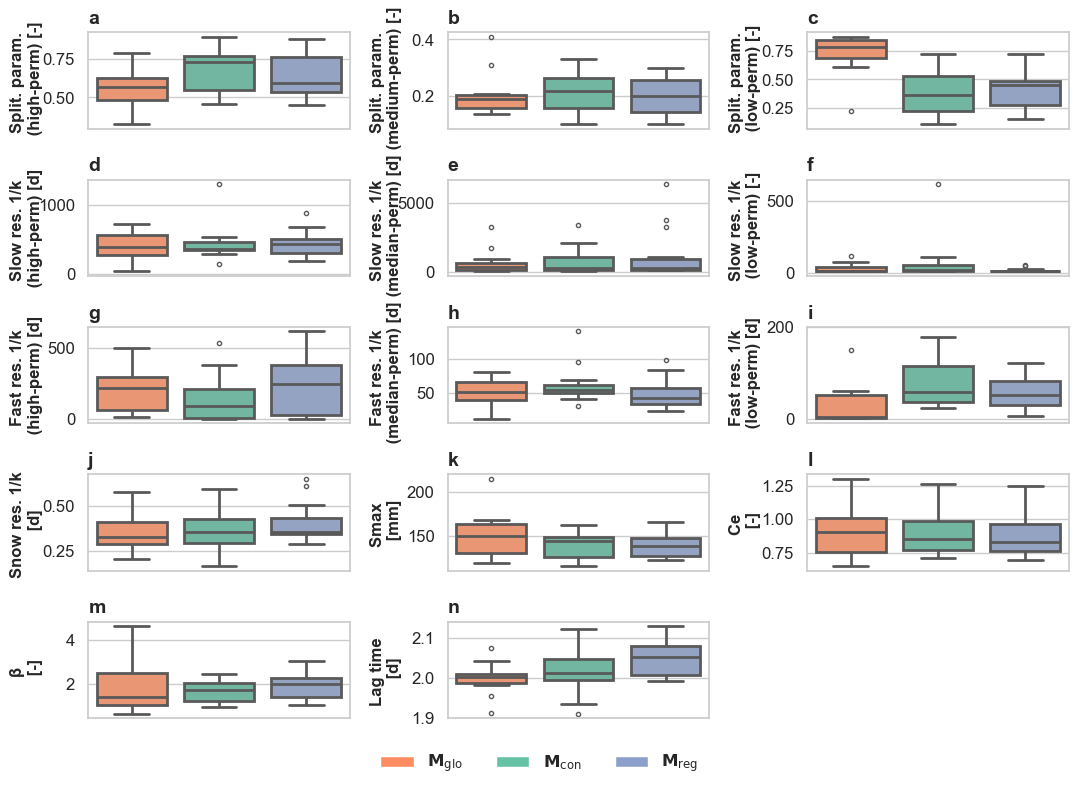

In [324]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

subplot_titles = list("abcdefghijklmnopqrstu")  # Enough for 26 variables


# Seaborn styling
sns.set_theme(style="whitegrid", font_scale=1.2)

# Prepare long-format data
def prepare_long_df(df, name):
    df_long = df.copy()
    df_long['source'] = name
    return df_long

regional_long = prepare_long_df(regional_params, 'Regional')
continental_long = prepare_long_df(continental_params, 'Continental')
global_long = prepare_long_df(global_params, 'Global')

all_long = pd.concat([global_long, continental_long, regional_long], axis=0)
all_long = all_long.melt(id_vars='source', var_name='variable', value_name='value')

# Colors for groups
palette = {
    'Regional': '#8da0cb',     # blue
    'Continental': '#66c2a5',  # green
    'Global': '#fc8d62'        # orange
}

# Variables to plot
variables = [

    'high_lowersplitter_splitpar', 
    'general_lowersplitter_splitpar',
    'low_lowersplitter_splitpar',

    'high_slow_k',
    'general_slow_k',
    'low_slow_k',
    
    'high_fast_k', 
    'general_fast_k',
    'low_fast_k',

    'high_snow_k', 
    'high_unsaturated_Smax', 
    'high_unsaturated_Ce',
    'high_unsaturated_beta', 
    'high_lag-fun_lag-time',
    ]


# Pretty labels for y-axes
pretty_labels = {
    'general_lowersplitter_splitpar': 'Split. param. \n (medium-perm) [-]',#
    'high_lowersplitter_splitpar': 'Split. param. \n (high-perm) [-]',#
    'low_lowersplitter_splitpar': 'Split. param. \n (low-perm) [-]',#
    'high_fast_k': 'Fast res. 1/k \n (high-perm) [d] ',#
    'high_slow_k': 'Slow res. 1/k \n (high-perm) [d] ',#
    'general_slow_k': 'Slow res. 1/k \n (median-perm) [d]',#
    'general_fast_k': 'Fast res. 1/k \n (median-perm) [d]',#
    'low_slow_k': 'Slow res. 1/k \n (low-perm) [-]',#
    'low_fast_k': 'Fast res. 1/k \n (low-perm) [d]',#

    'high_snow_k': 'Snow res. 1/k \n [d]',#
    'high_unsaturated_Smax': 'Smax \n [mm]',#
    'high_unsaturated_Ce': 'Ce \n [-]',#
    'high_unsaturated_beta': 'β \n [-]',#
    'high_lag-fun_lag-time': 'Lag time \n [d]',#




}

# Layout
ncols = 3
nrows = int(np.ceil(len(variables) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 8), sharey=False)
axes = axes.flatten()

# Plot
for i, var in enumerate(variables):
    ax = axes[i]
    sns.boxplot(
        data=all_long[all_long['variable'] == var],
        x='source', y='value',
        palette=palette,
        linewidth=2.0,
        fliersize=3,
        ax=ax
    )
    ax.set_title(subplot_titles[i], fontsize=14, weight='bold', loc="left")  # "A", "B", ...
    ax.set_xlabel('')
    ax.set_ylabel(pretty_labels.get(var, var), fontsize=12)
    ax.set_xticks([])  # remove x-axis group labels
    ax.tick_params(labelsize=12)

# Hide unused axes
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Custom legend
legend_elements = [
    Patch(facecolor=palette['Global'], label=r"$\mathbf{M_{\mathrm{glo}}}$"),
    Patch(facecolor=palette['Continental'], label=r"$\mathbf{M_{\mathrm{con}}}$"),
    Patch(facecolor=palette["Regional"], label=r"$\mathbf{M_{\mathrm{reg}}}$"),
]


fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=3,
    fontsize=12,
    frameon=False
)

# Align all y-axis labels
for ax in axes:
    ax.yaxis.set_label_coords(-0.175, 0.5)  # adjust -0.15 as needed

axes[8].set_ylim(-10, 200)
plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.savefig("../results/figs/boxplots_paramS.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()

# Supporting information

In [339]:
estreams_attributes_clipped_filters_plot_nodup_appendix = estreams_attributes_clipped_filters_plot_nodup.copy()

estreams_attributes_clipped_filters_plot_nodup_appendix["perm_high_cont2"] = estreams_attributes_clipped_filters_plot_nodup_appendix["perm_high_cont"] 
estreams_attributes_clipped_filters_plot_nodup_appendix["perm_medium_cont2"] = estreams_attributes_clipped_filters_plot_nodup_appendix["perm_medium_cont"] + estreams_attributes_clipped_filters_plot_nodup_appendix["perm_low_cont"]
estreams_attributes_clipped_filters_plot_nodup_appendix["perm_low_cont2"] = estreams_attributes_clipped_filters_plot_nodup_appendix["perm_verylow_cont"] 

estreams_attributes_clipped_filters_plot_nodup_appendix = estreams_attributes_clipped_filters_plot_nodup_appendix[['gauge_id', 
                                                                                                                  'gauge_name',
                                                                                                                  'gauge_country',
       'gauge_provider', 'river', 'lon_snap', 'lat_snap', 'area_official', 'area_estreams', 'area_flag', 'area_rel',
       'start_date', 'end_date', 'num_years', 'gauges_upstream', 'q_mean', 'q_runoff_ratio',
       'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index',
       'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time', 'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max',
       'ele_mt_mean', 'ele_mt_min', 'slp_dg_mean', 'flat_area_fra',
       'steep_area_fra', 'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',
        'lit_fra_su','lit_fra_ss', 'lit_fra_sm', 'lit_fra_sc', 'lit_fra_mt', 'lit_fra_pi',
       'lit_fra_py', 'lit_fra_vi', 'lit_fra_ev', 'lit_fra_ig', 'lit_fra_pa',
       'lit_fra_pb', 'lit_fra_va', 'lit_fra_vb', 

       'perm_high_regi', 'perm_medium_regi', 'perm_low_regi', 
       'perm_high_cont2', 'perm_medium_cont2', 'perm_low_cont2', 
       'perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',
       
       'root_dep_mean', 'root_dep_max',
       'root_dep_min', 'soil_tawc_mean', 'soil_fra_sand_mean',
       'soil_fra_silt_mean', 'soil_fra_clay_mean', 'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 
       
       'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'lakes_tot_area', 'lakes_tot_vol', 'sno_cov_mean', 'irri_1990',
       'irri_2005', 'stations_num_p_mean',  'nse_r1comp', 'nse_c1comp',
       'nse_g1comp', 'nse_nogeo']]

In [361]:
estreams_attributes_clipped_filters_plot_nodup_appendix.to_csv("../results/supporting_information/moselle_attributes.csv", index=True)

In [352]:
estreams_attributes_clipped_filters_plot_nodup_appendix.loc["FR003250"].iloc[-10:]

lakes_tot_area              0.0
lakes_tot_vol               0.0
sno_cov_mean             11.555
irri_1990                   0.0
irri_2005                   0.0
stations_num_p_mean         3.0
nse_r1comp             0.231655
nse_c1comp             0.280377
nse_g1comp             0.425633
nse_nogeo              0.392146
Name: FR003250, dtype: object

<Axes: >

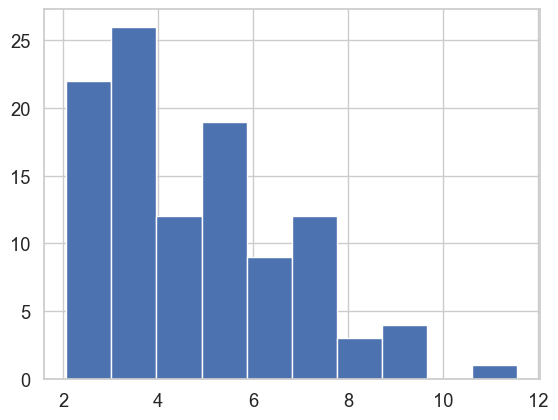

In [355]:
estreams_attributes_clipped_filters_plot_nodup_appendix.loc[:, "sno_cov_mean"].hist()

In [365]:
estreams_attributes_clipped_filters_plot_nodup_appendix[estreams_attributes_clipped_filters_plot_nodup_appendix.sno_cov_mean > 8.0]

gauge_id             gauge_name gauge_country gauge_provider  \
basin_id                                                                   
DERP2006  2628005000                  Pruem            DE          DE_RP   
FR000124  A402061001               A4020610            FR   FR_EAUFRANCE   
BEWA0067    99261002             Schoenberg            BE         BE_SPW   
FR000128  A420063001               A4200630            FR   FR_EAUFRANCE   
FR000125  A405062001               A4050620            FR   FR_EAUFRANCE   
FR003234  A417301001  La Cleurie Ã  Cleurie            FR   FR_EAUFRANCE   
DERP2021  2660030000             Juenkerath            DE          DE_RP   
FR003250  A600101001   La Meurthe Ã  Fraize            FR   FR_EAUFRANCE   

                                              river  lon_snap   lat_snap  \
basin_id                                                                   
DERP2006                                      Pruem  6.440000  50.219000   
FR000124            La Moselle à Fresse-sur-Moselle  6.796285  47.866921   
BEWA0067                                        Our  6.263467  50.289277   
FR000128  La Moselle à Remiremont et à Saint-Nabord  6.611131  48.067077   
FR000125              La Moselle à Rupt-sur-Moselle  6.685918  47.909445   
FR003234                       La Cleurie à Cleurie  6.690263  48.053183   
DERP2021                                       Kyll  6.601000  50.334000   
FR003250                        La Meurthe à Fraize  7.002529  48.184730   

          area_official  area_estreams  area_flag  ...  lakes_tot_area  \
basin_id                                           ...                   
DERP2006           53.2         54.000          0  ...            0.00   
FR000124           71.0         71.180          0  ...            0.00   
BEWA0067          101.0        101.033          0  ...            0.00   
FR000128          626.0        628.019          0  ...            0.00   
FR000125          152.0        151.499          0  ...            0.00   
FR003234           63.0         64.468          0  ...            0.00   
DERP2021          175.6        176.000          0  ...            0.15   
FR003250           67.0         67.143          0  ...            0.00   

         lakes_tot_vol sno_cov_mean  irri_1990  irri_2005  \
basin_id                                                    
DERP2006           0.0        8.568      0.000      0.000   
FR000124           0.0        9.412      0.000      0.000   
BEWA0067           0.0        8.920      0.000      0.075   
FR000128           0.0        8.738      0.036      0.030   
FR000125           0.0        8.587      0.000      0.000   
FR003234           0.0        9.623      0.000      0.000   
DERP2021           0.9        8.650      0.000      0.446   
FR003250           0.0       11.555      0.000      0.000   

          stations_num_p_mean  nse_r1comp  nse_c1comp  nse_g1comp  nse_nogeo  
basin_id                                                                      
DERP2006                  5.0    0.816822    0.779248    0.834235   0.731679  
FR000124                  9.0    0.807491    0.811396    0.753625   0.772476  
BEWA0067                  8.0    0.817378    0.793928    0.660304   0.729356  
FR000128                 13.0    0.884267    0.880618    0.832449   0.826265  
FR000125                  9.0    0.867887    0.864906    0.817932   0.809945  
FR003234                  2.0    0.604855    0.631859    0.649670   0.638194  
DERP2021                  9.0    0.856411    0.827006    0.862047   0.780903  
FR003250                  3.0    0.231655    0.280377    0.425633   0.392146  

[8 rows x 104 columns]

In [354]:
estreams_attributes_clipped_filters_plot_nodup_appendix.loc[:, "sno_cov_mean"].describe()

count    108.000000
mean       4.808231
std        2.028694
min        2.060000
25%        3.185000
50%        4.359500
75%        6.105250
max       11.555000
Name: sno_cov_mean, dtype: float64

In [349]:
estreams_attributes_clipped_filters_plot_nodup_appendix.iloc[:, 15:].corr(method='pearson')

q_mean  q_runoff_ratio  \
q_mean                     1.000000        0.937419   
q_runoff_ratio             0.937419        1.000000   
q_elas_Sankarasubramanian -0.236133       -0.285465   
slope_sawicz              -0.031707       -0.041907   
baseflow_index             0.080156        0.146864   
...                             ...             ...   
stations_num_p_mean       -0.067623       -0.039282   
nse_r1comp                 0.038372        0.038103   
nse_c1comp                 0.037126        0.034489   
nse_g1comp                 0.025689        0.023723   
nse_nogeo                  0.042663        0.040683   

                           q_elas_Sankarasubramanian  slope_sawicz  \
q_mean                                     -0.236133     -0.031707   
q_runoff_ratio                             -0.285465     -0.041907   
q_elas_Sankarasubramanian                   1.000000      0.065547   
slope_sawicz                                0.065547      1.000000   
baseflow_index                             -0.092800     -0.748320   
...                                              ...           ...   
stations_num_p_mean                        -0.064554     -0.074079   
nse_r1comp                                 -0.097003      0.242657   
nse_c1comp                                 -0.070969      0.261490   
nse_g1comp                                  0.019140      0.009072   
nse_nogeo                                   0.006118      0.225233   

                           baseflow_index  hfd_mean   hfd_std       q_5  \
q_mean                           0.080156  0.030028  0.173063  0.528998   
q_runoff_ratio                   0.146864  0.075959  0.061754  0.586286   
q_elas_Sankarasubramanian       -0.092800  0.104322  0.311142 -0.225421   
slope_sawicz                    -0.748320 -0.667265 -0.158399 -0.691998   
baseflow_index                   1.000000  0.852110  0.136244  0.739928   
...                                   ...       ...       ...       ...   
stations_num_p_mean              0.127596 -0.015781 -0.176121  0.011463   
nse_r1comp                      -0.333882 -0.546449 -0.407645 -0.297194   
nse_c1comp                      -0.330181 -0.546572 -0.398487 -0.327872   
nse_g1comp                      -0.264851 -0.417025 -0.238105 -0.147280   
nse_nogeo                       -0.366010 -0.576514 -0.209369 -0.292993   

                               q_95   hq_freq  ...  lakes_tot_area  \
q_mean                     0.956580 -0.323942  ...       -0.089927   
q_runoff_ratio             0.865283 -0.378738  ...       -0.085968   
q_elas_Sankarasubramanian -0.218406  0.246019  ...        0.134857   
slope_sawicz               0.184256  0.729777  ...       -0.075101   
baseflow_index            -0.177820 -0.825440  ...        0.138322   
...                             ...       ...  ...             ...   
stations_num_p_mean       -0.076800 -0.183428  ...        0.812368   
nse_r1comp                 0.147243  0.072993  ...        0.209340   
nse_c1comp                 0.153146  0.089105  ...        0.237912   
nse_g1comp                 0.087363 -0.007412  ...        0.268387   
nse_nogeo                  0.144946  0.072540  ...        0.215965   

                           lakes_tot_vol  sno_cov_mean  irri_1990  irri_2005  \
q_mean                         -0.070360      0.736441  -0.074485  -0.081671   
q_runoff_ratio                 -0.054282      0.794554  -0.058133  -0.052145   
q_elas_Sankarasubramanian       0.092614     -0.320903   0.018614  -0.023360   
slope_sawicz                   -0.077293      0.115867   0.002110   0.047793   
baseflow_index                  0.169650      0.039849   0.080222   0.024471   
...                                  ...           ...        ...        ...   
stations_num_p_mean             0.844913     -0.082998   0.944025   0.916431   
nse_r1comp                      0.215724     -0.000352   0.220460   0.260424   
nse_c1comp                      0.236810     -0.028274   0.243909

In [362]:
estreams_attributes_clipped_filters_plot_nodup_appendix.iloc[:, 15:].corr(method='pearson').to_csv("../results/supporting_information/moselle_attributes_correlation_pearson.csv", index=True)
estreams_attributes_clipped_filters_plot_nodup_appendix.iloc[:, 15:].corr(method='spearman').to_csv("../results/supporting_information/moselle_attributes_correlation_spearman.csv", index=True)

# End